## Nucleosome association analysis
Nucleosomes called using the "occ" function from NucleoATAC package

Reference Figure 3e of Buenrostro et al 2013 original ATAC-seq paper

In [1]:
library(tidyverse)
library(GenomicRanges)
library(viridis)
library(ComplexHeatmap)
library(circlize)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data

# single TF

### inputs

In [ ]:
base_dir <- "../../"
motif_pos_file <- paste0(base_dir, "/output/02-atac/03/motif.scores.JASPAR2020.pos.rds")
TF <- "TCF3"
valid_chr <- paste0("chr", c(as.character(1:22), "X"))

if (TF=="SPI1"){
    sample_ls <- c("HEK293T_P1A12_GFP_d100", "HEK293T_P3E11_SPI1_d005", "HEK293T_P3E10_SPI1_d025", "HEK293T_P3E9_SPI1_d050", "HEK293T_P3E8_SPI1_d075", "HEK293T_P3E7_SPI1_d100",
                 "HEK293T_P1B12_GFP_d100", "HEK293T_P3G11_SPI1_d005", "HEK293T_P3G10_SPI1_d025", "HEK293T_P3G9_SPI1_d050", "HEK293T_P3G8_SPI1_d075", "HEK293T_P3G7_SPI1_d100")
} else{
    if (TF=="KLF1"){
        sample_ls <- c("HEK293T_P1A12_GFP_d100", "HEK293T_P3H6_KLF1_d005", "HEK293T_P3H5_KLF1_d025", "HEK293T_P3H4_KLF1_d050", "HEK293T_P3H3_KLF1_d075", "HEK293T_P3H2_KLF1_d100",
                       "HEK293T_P1B12_GFP_d100", "HEK293T_P3E6_KLF1_d005", "HEK293T_P3E5_KLF1_d025", "HEK293T_P3E4_KLF1_d050", "HEK293T_P3E3_KLF1_d075", "HEK293T_P3E2_KLF1_d100")
    } else{
        sample_ls <- c("HEK293T_P1A12_GFP_d100", "HEK293T_P1B12_GFP_d100", basename(Sys.glob(paste0(base_dir, "/output/02-atac/12/HEK293T*", TF, "*"))))
    }
}
print(sample_ls)

outdir <- paste0(base_dir, "/output/02-atac/13")
plotdir <- paste0(base_dir, "/plots/02-atac/13")
dir.create(outdir, showWarnings=F)
dir.create(plotdir, showWarnings=F)

motif_code_ls <- c("ALX4"="MA0681.2_PHOX2B",
                   "ELF1"="MA0473.3_ELF1",
                   "IRF4"="MA1419.1_IRF4",
                   "KLF1"="MA0039.4_KLF4",
                   "KLF4"="MA0039.4_KLF4",
                   "LEF1"="MA0768.1_LEF1",
                #    "NR4A1"="MA1112.2_NR4A1",
                   "OCT4"="MA1115.1_POU5F1",
                #    "PRDM1"="MA0508.3_PRDM1",
                   "SOX2"="MA0143.4_SOX2",
                   "SP4"="MA0685.1_SP4",
                   "SPI1"="MA0080.5_SPI1",
                   "TCF3"="MA0522.3_TCF3")

chrombpnet_motif_code_ls <- c("ALX4"="pos_patterns.ALX.HD",
                   "ELF1"="pos_patterns.ETS_single_2",
                   "IRF4"="pos_patterns.IRF_single",
                   "KLF1"="pos_patterns.SP.KLF_single_1",
                   "KLF4"="pos_patterns.SP.KLF_single_1",
                   "LEF1"="pos_patterns.LEF_single",
                   "OCT4"="pos_patterns.POU_single",
                   "SOX2"="pos_patterns.SOX_single",
                   "SP4"="pos_patterns.SP.KLF_single",
                   "SPI1"="pos_patterns.ETS_single",
                   "TCF3"="pos_patterns.bHLH_single")


 [1] "HEK293T_P1A12_GFP_d100"  "HEK293T_P1B12_GFP_d100" 
 [3] "HEK293T_P2E10_TCF3_d025" "HEK293T_P2E11_TCF3_d005"
 [5] "HEK293T_P2E7_TCF3_d100"  "HEK293T_P2E8_TCF3_d075" 
 [7] "HEK293T_P2E9_TCF3_d050"  "HEK293T_P2F10_TCF3_d025"
 [9] "HEK293T_P2F11_TCF3_d005" "HEK293T_P2F7_TCF3_d100" 
[11] "HEK293T_P2F8_TCF3_d075"  "HEK293T_P2F9_TCF3_d050" 


In [ ]:
nucleo_ls <- list()
for (sample in sample_ls){
    tmp <- read_tsv(paste0(base_dir, "/output/02-atac/12/", sample, "/", sample, ".occpeaks.bed.gz"), 
                    col_names=c("seqnames", "0-start", "start", "occ", "occ_lower", "occ_upper", "nread_121bp")) %>% dplyr::filter(seqnames %in% valid_chr)
    tmp$end <- tmp$start + 1
    nucleo_ls[[sample]] <- tmp
    # print(ggplot(tmp, aes(y=occ_lower)) + geom_boxplot())
}
head(nucleo_ls[[sample_ls[1]]])

Rows: 714123 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): seqnames
dbl (6): 0-start, start, occ, occ_lower, occ_upper, nread_121bp

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 589524 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): seqnames
dbl (6): 0-start, start, occ, occ_lower, occ_upper, nread_121bp

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 394666 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): seqnames
dbl (6): 0-start, start, occ, occ_lower, occ_upper, nread_121bp

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specif

seqnames,0-start,start,occ,occ_lower,occ_upper,nread_121bp,end
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,57113,57114,1,0.1030691,1,1,57115
chr1,191337,191338,1,0.1253433,1,1,191339
chr1,263765,263766,1,0.1037638,1,1,263767
chr1,268215,268216,1,0.2507042,1,2,268217
chr1,702297,702298,1,0.1183533,1,1,702299
chr1,778473,778474,1,0.6703845,1,7,778475


### method1: use motifmatchr results

In [4]:
motifs_raw <- readRDS(motif_pos_file)
motifs <- list()
for (n in names(motifs_raw)){
    tmp <- motifs_raw[[n]][(seqnames(motifs_raw[[n]]) %>% as.character) %in% valid_chr]
    seqlevels(tmp) <- valid_chr
    motifs[[n]] <- tmp
}
motifs <- GRangesList(motifs)
head(motifs)

GRangesList object of length 6:
$MA0030.1_FOXF2
GRanges object with 44363 ranges and 1 metadata column:
          seqnames              ranges strand |     score
             <Rle>           <IRanges>  <Rle> | <numeric>
      [1]     chr1       944553-944566      + |   13.4523
      [2]     chr1       975823-975836      + |   13.6073
      [3]     chr1     1204946-1204959      + |   14.7759
      [4]     chr1     1237592-1237605      + |   13.3462
      [5]     chr1     1359374-1359387      + |   14.4786
      ...      ...                 ...    ... .       ...
  [44359]     chrX 155263307-155263320      + |   15.1728
  [44360]     chrX 155264789-155264802      + |   12.7710
  [44361]     chrX 155305130-155305143      - |   13.1972
  [44362]     chrX 155399870-155399883      + |   14.6610
  [44363]     chrX 155624458-155624471      - |   13.7412
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

...
<5 more elements>

In [5]:
buenrostro_motif_list <- c("C-FOS", "IRF3", "NFYA", # strongly nucleosome avoiding
                            "ZNF143", "RAD21", "SMC3", "CTCF", # CTCF like
                             "NFYB", "JUND", "NFE2", "P300B", "SREBP2", "NRF1", "RFX5", "E2F4", "ELK1", "P300", "MAX", "MAZ", "BHLHE40", # nucleosome avoiding to insensitive
                             "USF2", "CHD2", "COREST", "STAT3", "TBLR1", "SPT20", "STAT1", "TR4", "TBP", "MXI1", "ERRA", "EBF1", "MAFK", # nucleosome avoiding to insensitive
                             "SREBP1", "CDP", "IKZF1", "BRCA1", # nucleosome avoiding to insensitive
                             "YY1", "POL2", "POL2s2", "GCN5", "ZZZ3", "ZNF384", "WHIP", "SIN3A", "CHD1") # nucleosome adjacent/associated
match_buenrostro_motifs <- lapply(buenrostro_motif_list, function(x){grep(x, names(motifs), value=T)}) %>% unlist

In [6]:
motifs_to_test <- c(motif_code_ls %>% unname, match_buenrostro_motifs)
head(motifs_to_test)
suffix <- ""

[1] "MA0681.2_PHOX2B" "MA0473.3_ELF1"   "MA1419.1_IRF4"   "MA0039.4_KLF4"  
[5] "MA0039.4_KLF4"   "MA0768.1_LEF1"

### method2: use motif hits from ChromBPNet, highest dose

In [ ]:
motif_hits_file <- Sys.glob(paste0(base_dir, "/output/04-chrombpnet/output/models/fold_0/HEK293T_*", TF,"_d100/finemo_out/", TF,"/hits.bed.gz"))
motifs_raw <- read_tsv(motif_hits_file, col_names=c("seqnames", "start", "end", "name", "score", "strand"))
head(motifs_raw)

Rows: 4574665 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): seqnames, name, strand
dbl (3): start, end, score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


seqnames,start,end,name,score,strand
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
chr1,10167,10177,neg_patterns.ZBT7__merged_pattern_0,676.6726,-
chr1,778629,778633,pos_patterns.CG__merged_pattern_1,686.7885,-
chr1,778668,778690,pos_patterns.CG__merged_pattern_4,713.4435,-
chr1,778675,778684,pos_patterns.SP.KLF__merged_pattern_0,706.6729,+
chr1,778712,778720,pos_patterns.JUN.FOS_1__merged_pattern_0,811.7351,-
chr1,778744,778751,pos_patterns.NFY.pos__merged_pattern_0,812.2938,-


In [44]:
motifs_raw["motif"] <- str_split(motifs_raw$name, "__", simplify=T)[,1]
motifs <- list()
for (n in unique(motifs_raw$motif)){
    tmp <- motifs_raw %>% dplyr::filter((seqnames %in% valid_chr) & (motif==n)) %>% GRanges
    seqlevels(tmp) <- valid_chr
    motifs[[n]] <- tmp
}
motifs <- GRangesList(motifs)
head(motifs)

GRangesList object of length 6:
$neg_patterns.ZBT7
GRanges object with 134336 ranges and 3 metadata columns:
           seqnames              ranges strand |                   name
              <Rle>           <IRanges>  <Rle> |            <character>
       [1]     chr1         10167-10177      - | neg_patterns.ZBT7__m..
       [2]     chr1       779216-779226      - | neg_patterns.ZBT7__m..
       [3]     chr1       869750-869769      - | neg_patterns.ZBT7__m..
       [4]     chr1       904857-904867      + | neg_patterns.ZBT7__m..
       [5]     chr1       905989-906008      - | neg_patterns.ZBT7__m..
       ...      ...                 ...    ... .                    ...
  [134332]     chrX 155335120-155335130      + | neg_patterns.ZBT7__m..
  [134333]     chrX 155430308-155430318      + | neg_patterns.ZBT7__m..
  [134334]     chrX 155435363-155435373      - | neg_patterns.ZBT7__m..
  [134335]     chrX 155435975-155435985      - | neg_patterns.ZBT7__m..
  [134336]     chrX 1556447

In [45]:
motifs_to_test <- names(motifs)
print(motifs_to_test)
suffix <- "_chrombphits"

 [1] "neg_patterns.ZBT7"          "pos_patterns.CG"           
 [3] "pos_patterns.SP.KLF"        "pos_patterns.JUN.FOS_1"    
 [5] "pos_patterns.NFY.pos"       "pos_patterns.CTCF"         
 [7] "pos_patterns.ETS_single"    "neg_patterns.SNAI"         
 [9] "neg_patterns.Average_11"    "neg_patterns.Average_22"   
[11] "neg_patterns.Average_19"    "pos_patterns.ETS_HT"       
[13] "pos_patterns.ETS_HH"        "neg_patterns.Average_18"   
[15] "pos_patterns.HOX.HD"        "pos_patterns.NRF1"         
[17] "neg_patterns.NFY.neg"       "pos_patterns.ETS_TT"       
[19] "pos_patterns.ETS_overlap_1" "pos_patterns.ETS_overlap_2"
[21] "pos_patterns.repeat_A"      "pos_patterns.SPI1_d005"    
[23] "pos_patterns.SIX.HD"        "pos_patterns.FOX"          
[25] "pos_patterns.JUN.FOS_2"     "pos_patterns.ETS_multimer" 
[27] "pos_patterns.repeat_TC"     "pos_patterns.SIX.ETS"      
[29] "pos_patterns.ETS_SP.KLF_2"  "pos_patterns.C2H2_ZF"      
[31] "pos_patterns.ETS_6mer"      "pos_patterns.repeat_

### distance only

In [7]:
# this take ~10min
output <- list()

#suppressWarnings()
# iterate through motifs to test
#for (i in seq(1, length(motifs_to_test))){ # use this normally
motifs_to_test <- c(motif_code_ls[TF]) # test code, use this if only interested in the one motif
for (i in seq(1, 1)){    
    message("----------------------")
    message(motifs_to_test[i])
    m <- motifs[[motifs_to_test[i]]]
    
    # iterate through diff nucleosome position sets 
    for (j in seq(1, length(nucleo_ls))){
        message(paste0("> ", names(nucleo_ls)[j]))
        nuc <- nucleo_ls[[j]] %>% GRanges

        # get distances to nearest dyad center
        dist_to_nuc <- distanceToNearest(m, nuc)
        mcols(dist_to_nuc) <- cbind(mcols(dist_to_nuc), mcols(nuc[dist_to_nuc@to]))

        # fine: this only looks at motifs within 250bp of a nucleosome, bin 10bp
        breaks <- seq(0, 250, by = 10)

        dist <- cut(mcols(dist_to_nuc)$distance, breaks) 
        mcols(dist_to_nuc)$dist_bin <- dist
        df <- mcols(dist_to_nuc) %>% as.data.frame %>% dplyr::group_by(dist_bin) %>% dplyr::summarise(motif_count=n(), avg_occ_lower=mean(occ_lower), 
                                                                            avg_occ=mean(occ), avg_occ_upper=mean(occ_upper), avg_nread_121bp=mean(nread_121bp),
                                                                            med_occ_lower=median(occ_lower), med_occ=median(occ), med_occ_upper=median(occ_upper),
                                                                            med_nread_121bp=median(nread_121bp),
                                                                            )
        df <- df[!is.na(df$dist_bin),]
        df$breaks <- str_split(str_split(as.character(df$dist_bin), ",", simplify=T)[,1],
                                pattern='\\(', simplify=T)[,2] %>% as.numeric
        df$motif <- motifs_to_test[i]
        df$model <- names(nucleo_ls)[j]
        output <- c(output, DataFrame(df)) 
    }   
}

----------------------

MA0522.3_TCF3

> HEK293T_P1A12_GFP_d100



> HEK293T_P1B12_GFP_d100

> HEK293T_P2E10_TCF3_d025

> HEK293T_P2E11_TCF3_d005

> HEK293T_P2E7_TCF3_d100

> HEK293T_P2E8_TCF3_d075

> HEK293T_P2E9_TCF3_d050

> HEK293T_P2F10_TCF3_d025

> HEK293T_P2F11_TCF3_d005

> HEK293T_P2F7_TCF3_d100

> HEK293T_P2F8_TCF3_d075

> HEK293T_P2F9_TCF3_d050



In [8]:
output <- do.call(rbind, output)
dim(output)
head(output)

[1] 300  13

DataFrame with 6 rows and 13 columns
  dist_bin motif_count avg_occ_lower   avg_occ avg_occ_upper avg_nread_121bp
  <factor>   <integer>     <numeric> <numeric>     <numeric>       <numeric>
1  (0,10]         1552      0.319863  0.965857      0.991665         3.10309
2  (10,20]        1571      0.317188  0.970197      0.993212         2.97645
3  (20,30]        1570      0.319788  0.971572      0.993550         2.98535
4  (30,40]        1555      0.318672  0.975646      0.994746         2.90289
5  (40,50]        1515      0.308490  0.966632      0.991549         3.04422
6  (50,60]        1447      0.321361  0.970179      0.992324         3.15964
  med_occ_lower   med_occ med_occ_upper med_nread_121bp    breaks         motif
      <numeric> <numeric>     <numeric>       <numeric> <numeric>   <character>
1      0.292154         1             1               2         0 MA0522.3_TCF3
2      0.288953         1             1               2        10 MA0522.3_TCF3
3      0.299098         1  

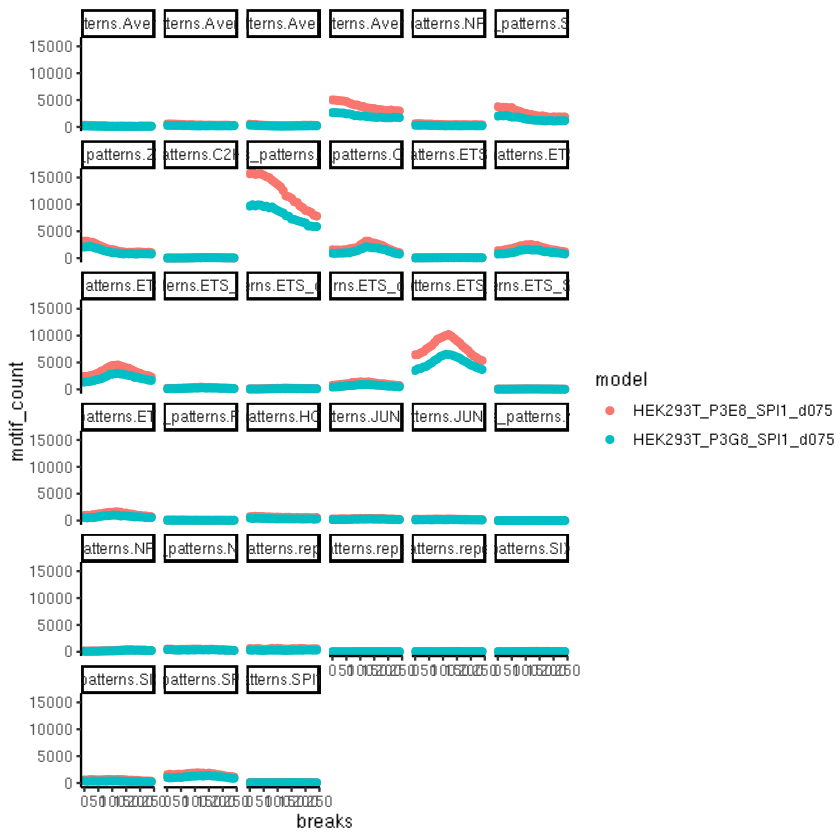

In [21]:
# # plot replicates for reproducibility
# ggplot(output[grepl(paste0(TF, "_d075"),output$model),], aes(x=breaks, y=motif_count, color=model)) + geom_point() + 
#     theme_classic() + facet_wrap(~motif)
# ggsave(paste0(plotdir, "/reps_", TF, "_d075_models_motif_counts_scaled_vs_dist_dyad_facet_by_motif", suffix, ".pdf"), width=10, height=12)

In [9]:
output$dose <- str_split(output$model, "_d", simplify=T)[,2] %>% as.numeric
output[grepl("GFP", output$model), "dose"] <- 0
# average replicates
output <- output %>% as.data.frame %>% group_by(motif, dose, breaks) %>% 
            dplyr::summarise(motif_count=mean(motif_count),
                             avg_occ=mean(avg_occ),
                             avg_occ_lower=mean(avg_occ_lower),
                             avg_occ_upper=mean(avg_occ_upper),
                             avg_nread_121bp=mean(avg_nread_121bp),
                             med_occ=mean(med_occ),
                             med_occ_lower=mean(med_occ_lower),
                             med_occ_upper=mean(med_occ_upper),
                             med_nread_121bp=mean(med_nread_121bp)) %>% 
                             dplyr::mutate(countxocc=avg_occ*motif_count) %>%
                             as.data.frame

# 0 to 1 scale per dose per motif per group
for (m in unique(output$motif)){
    for (d in unique(output$dose)){
        idx <- (output$dose==d) & (output$motif==m)
        tmp <- scales::rescale(output[idx, "motif_count"])
        tmp2 <- scales::rescale(output[idx, "countxocc"])
        output[idx, "motif_count_scaled"] <- tmp 
        output[idx, "countxocc_scaled"] <- tmp2 
    
    }
}
head(output)

`summarise()` has grouped output by 'motif', 'dose'. You can override using the
`.groups` argument.


,motif,dose,breaks,motif_count,avg_occ,avg_occ_lower,avg_occ_upper,avg_nread_121bp,med_occ,med_occ_lower,med_occ_upper,med_nread_121bp,countxocc,motif_count_scaled,countxocc_scaled
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,MA0522.3_TCF3,0,0,1626.0,0.9507489,0.3458628,0.9868601,3.938017,1,0.3223363,1,2.5,1545.918,1.0000000,1.0000000
2,MA0522.3_TCF3,0,10,1615.0,0.9553136,0.3476573,0.9884132,3.841750,1,0.3216729,1,2.5,1542.832,0.9875566,0.9962412
3,MA0522.3_TCF3,0,20,1596.0,0.9539901,0.3512397,0.9875895,4.041072,1,0.3321397,1,2.5,1522.568,0.9660633,0.9715617
4,MA0522.3_TCF3,0,30,1602.0,0.9582315,0.3477855,0.9892624,3.811059,1,0.3250636,1,2.5,1535.087,0.9728507,0.9868085
5,MA0522.3_TCF3,0,40,1561.0,0.9522857,0.3455863,0.9869935,4.028957,1,0.3194237,1,2.5,1486.518,0.9264706,0.9276547
6,MA0522.3_TCF3,0,50,1529.5,0.9544664,0.3524723,0.9881002,4.094398,1,0.3242564,1,2.5,1459.856,0.8908371,0.8951825


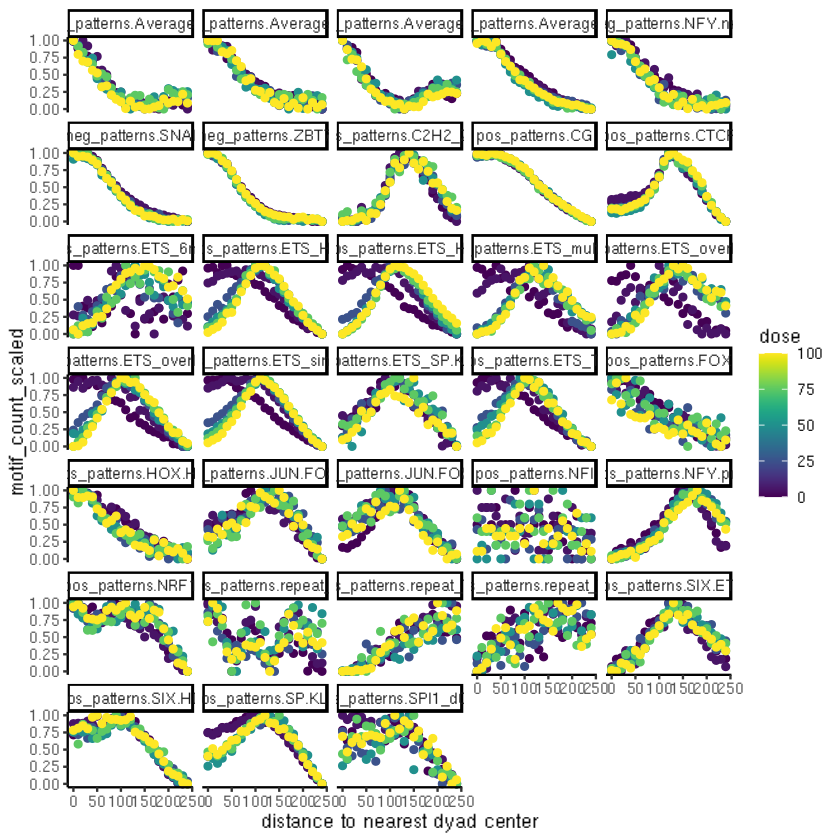

In [24]:
# ggplot(output, aes(x=breaks, y=motif_count_scaled, color=dose)) + geom_point() + theme_classic() + 
#             facet_wrap(~motif, ncol=5) + xlab("distance to nearest dyad center") + scale_color_viridis()
# ggsave(paste0(plotdir, "/", TF, "_models_motif_counts_scaled_vs_dist_dyad_facet_by_motif", suffix, ".pdf"), width=10, height=12)

           TCF3 
"MA0522.3_TCF3" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


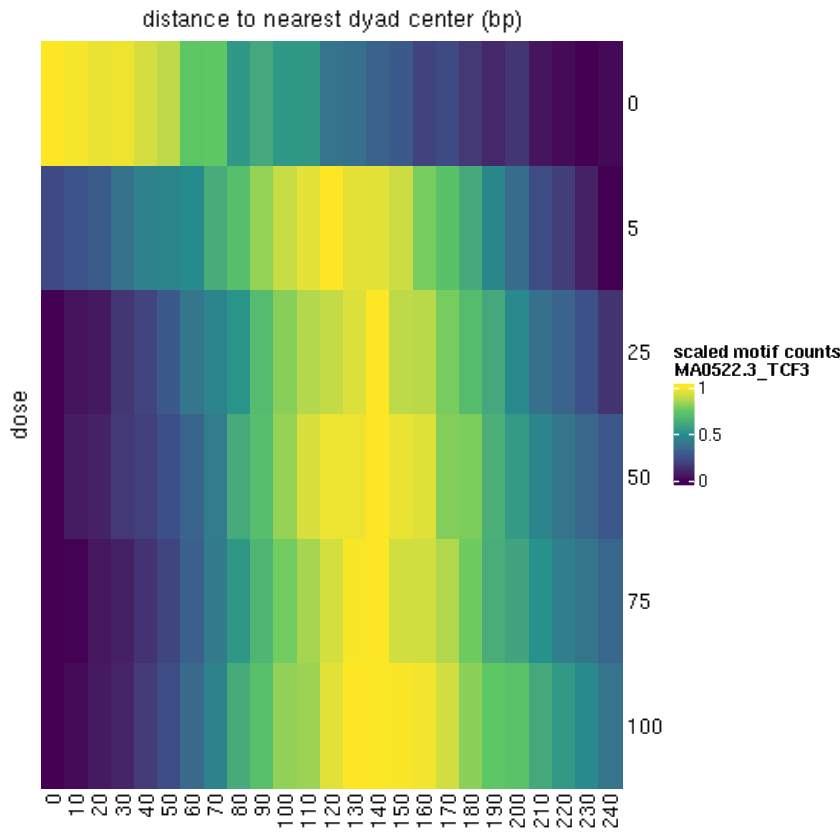

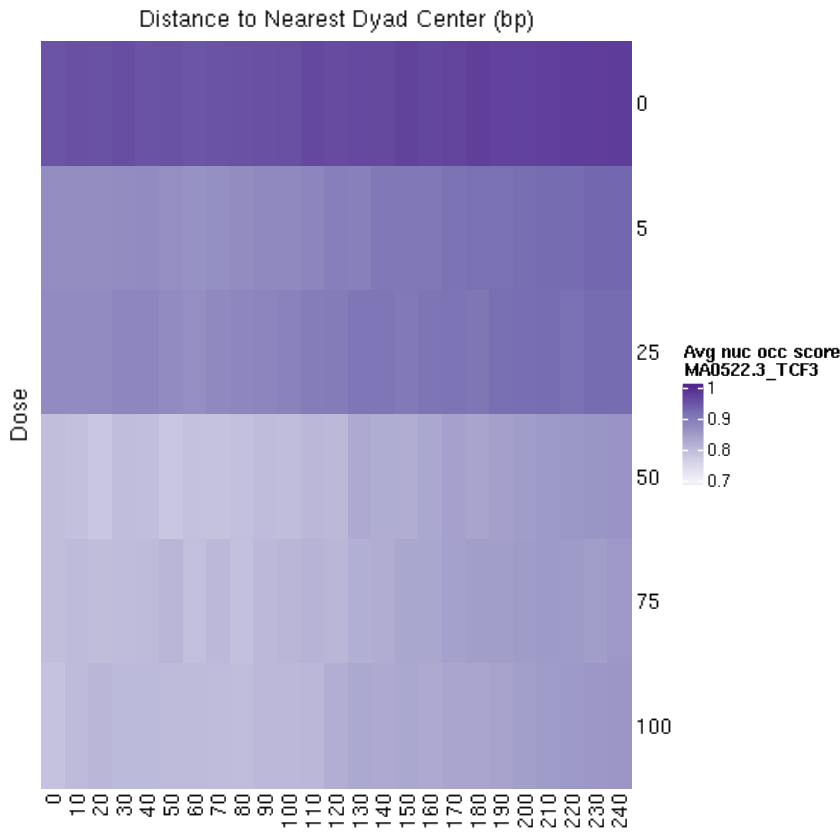

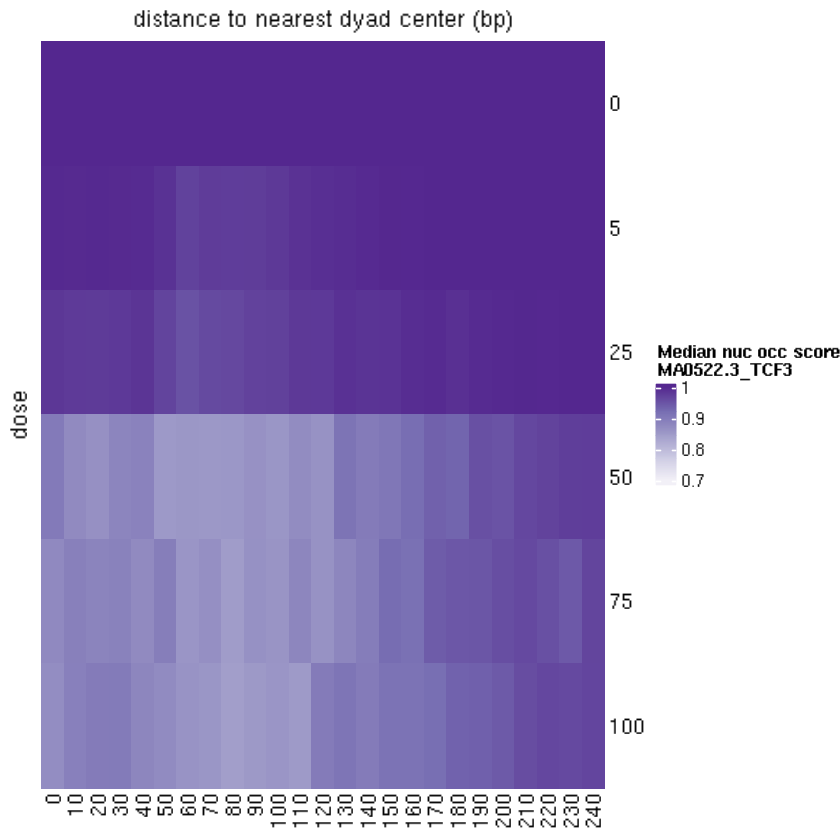

In [10]:
# m <- grep("ETS_single", motifs_to_test, value=T) # if chrombpnet hits
m <- motif_code_ls[TF]
print(m)
subset <- output %>% as.data.frame %>% dplyr::filter(motif==m)

# define a color palette for motif counts
min_value <- 0
max_value <- 1
num_colors <- 5
col_palette <- colorRamp2(breaks=seq(min_value, max_value, length.out = num_colors), colors=viridis(num_colors))

mat <- reshape2::dcast(subset, dose ~ breaks, value.var="motif_count_scaled") %>% column_to_rownames("dose") 
ht1 <- Heatmap(mat,
        name=paste0("scaled motif counts\n",m ),
        column_title="distance to nearest dyad center (bp)",
        row_title="dose",
        cluster_columns=F,
        cluster_rows=F,
        col = col_palette,
        na_col = "grey")

# define a color palette for occupancy scores
min_value <- 0.7 
max_value <- 1
num_colors <- 5
col_palette <- colorRamp2(breaks=seq(min_value, max_value, length.out = num_colors), colors=brewer.pal(num_colors, "Purples"))

mat <- reshape2::dcast(subset, dose ~ breaks, value.var="avg_occ") %>% column_to_rownames("dose") 
ht2 <- Heatmap(mat,
        name = paste0("Avg nuc occ score\n", m),
        column_title = "Distance to Nearest Dyad Center (bp)",
        row_title = "Dose",
        cluster_columns = F,
        cluster_rows = F,
        col = col_palette,
        na_col = "grey")

mat <- reshape2::dcast(subset, dose ~ breaks, value.var="med_occ") %>% column_to_rownames("dose") 
ht3 <- Heatmap(mat,
        name=paste0("Median nuc occ score\n",m ),
        column_title="distance to nearest dyad center (bp)",
        row_title="dose",
        cluster_columns=F,
        cluster_rows=F,
        col = col_palette,
        na_col = "grey")
# pdf(paste0(plotdir, "/", TF, "_models_",m,"_heatmap_dist_dyad", suffix, ".pdf"), width=6, height=6)
draw(ht1)
draw(ht2)
draw(ht3)
# dev.off()

In [14]:
#d <- 75
for (d in c(0, 5, 25, 50, 75, 100)){
        subset <- output %>% as.data.frame %>% dplyr::filter(dose==d)
        mat <- reshape2::dcast(subset, motif ~ breaks, value.var="motif_count_scaled") %>% column_to_rownames("motif") 
        head(mat)
        ht <- Heatmap(mat,
                name=paste0("scaled motif counts\ndose=", d),
                column_title="distance to nearest dyad center (bp)",
                row_title="motif",
                cluster_columns=F)
        pdf(paste0(plotdir, "/", TF, "_models_dose", d, "_motifs_heatmap_dist_dyad", suffix, ".pdf"), width=8, height=10)
        draw(ht)
        dev.off()
}

Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


In [15]:
rownames(mat)[row_order(ht)]

Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”


[1] "MA0060.3_NFYA"               "MA0502.2_NFYB"              
 [3] "MA0685.1_SP4"                "MA1143.1_FOSL1::JUND(var.2)"
 [5] "MA0526.3_USF2"               "MA1102.2_CTCFL"             
 [7] "MA0510.2_RFX5"               "MA0506.1_NRF1"              
 [9] "MA0470.2_E2F4"               "MA0501.1_MAF::NFE2"         
[11] "MA0089.2_NFE2L1"             "MA0496.3_MAFK"              
[13] "MA0492.1_JUND(var.2)"        "MA1145.1_FOSL2::JUND(var.2)"
[15] "MA1141.1_FOS::JUND"          "MA0491.2_JUND"              
[17] "MA1142.1_FOSL1::JUND"        "MA0841.1_NFE2"              
[19] "MA1144.1_FOSL2::JUND"        "MA0028.2_ELK1"              
[21] "MA0139.1_CTCF"               "MA0464.2_BHLHE40"           
[23] "MA0059.1_MAX::MYC"           "MA0058.3_MAX"               
[25] "MA0039.4_KLF4"               "MA1522.1_MAZ"               
[27] "MA0473.3_ELF1"               "MA0095.2_YY1"               
[29] "MA1112.2_NR4A1"              "MA1108.2_MXI1"              
[31] "MA0595.1_SREBF1"             "MA0088.2_ZNF143"            
[33] "MA0522.3_TCF3"               "MA0154.4_EBF1"              
[35] "MA0144.2_STAT3"              "MA0137.3_STAT1"             
[37] "MA1508.1_IKZF1"              "MA0508.3_PRDM1"             
[39] "MA0143.4_SOX2"               "MA1419.1_IRF4"              
[41] "MA0829.2_SREBF1(var.2)"      "MA0080.5_SPI1"              
[43] "MA0768.1_LEF1"               "MA1115.1_POU5F1"            
[45] "MA1418.1_IRF3"               "MA0517.1_STAT1::STAT2"      
[47] "MA0681.2_PHOX2B"             "MA1125.1_ZNF384"

In [16]:
# SPI1 chrombp hits manual order
# hits <- c("pos_patterns.repeat_TC", "pos_patterns.repeat_TA", "pos_patterns.ETS_6mer", "pos_patterns.NFY.pos", 
#         "pos_patterns.C2H2_ZF", "pos_patterns.CTCF", "pos_patterns.SIX.ETS", "pos_patterns.JUN.FOS_1", "pos_patterns.JUN.FOS_2",
#         "pos_patterns.ETS_SP.KLF_2", "pos_patterns.ETS_overlap_1", "pos_patterns.ETS_overlap_2", "pos_patterns.ETS_multimer",  
#         "pos_patterns.ETS_single", "pos_patterns.ETS_HT", "pos_patterns.ETS_HH", "pos_patterns.ETS_TT", 
#         "pos_patterns.SPI1_d005",
#         "pos_patterns.SP.KLF", "pos_patterns.NRF1", "pos_patterns.SIX.HD", "pos_patterns.FOX",
#         "pos_patterns.CG", "pos_patterns.FOX", "pos_patterns.HOX.HD",
#         "neg_patterns.Average_22", "neg_patterns.Average_18", "neg_patterns.NFY.neg", 
#         "neg_patterns.SNAI", "neg_patterns.Average_19", "neg_patterns.ZBT7", "neg_patterns.Average_11",
#         "pos_patterns.repeat_A", "pos_patterns.NFI") 

hits <- rownames(mat)[row_order(ht)] # use the d100 hierarchical clustering row order

for (d in c(0, 5, 25, 50, 75, 100)){
    subset <- output %>% as.data.frame %>% dplyr::filter(dose==d)
    mat <- reshape2::dcast(subset, motif ~ breaks, value.var="motif_count_scaled") %>% column_to_rownames("motif") 
    mat <- mat[hits,]
    head(mat)
    ht <- Heatmap(mat,
            name=paste0("scaled motif counts\ndose=", d),
            column_title="distance to nearest dyad center (bp)",
            row_title="motif",
            cluster_columns=F,
            cluster_rows=F)

    pdf(paste0(plotdir, "/", TF, "_models_dose", d, "_motifs_heatmap_dist_dyad", suffix,"_manualorder.pdf"), width=8, height=10)
    draw(ht)
    dev.off()

}


Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


### enrichment

In [ ]:
output <- list()

#suppressWarnings()
# iterate through motifs to test
n_allmotif_total <- length(unlist(motifs))
#for (i in seq(1, length(motifs_to_test))){
for (i in seq(1, 2)){
    message("----------------------")
    message(motifs_to_test[i])
    m <- motifs[[motifs_to_test[i]]]

    # iterate through diff nucleosome position sets 
    for (j in seq(1, length(nucleo_ls))){
        message(paste0("> ", names(nucleo_ls)[j]))
        nuc <- nucleo_ls[[j]] %>% GRanges

        # iterate through different distances to dyad center
#        for (dist in seq(0, 250, 10)){
        for (dist in seq(0, 50, 10)){
            overlap <- findOverlaps(m, nuc+dist)
            n_currmotif_nearnuc <- length(overlap@from)
            n_currmotif_total <- length(m)

            
            overlap <- findOverlaps(unlist(motifs), nuc+dist)
            n_allmotif_nearnuc <- length(overlap@from)
                    
            # fisher's exact test to assess enrichment of a given motif within a certain distance of dyad centers
            if (dist != 0){
                n_currmotif_nearnuc <- n_currmotif_nearnuc - output[-1]$n_currmotif_nearnuc
                n_currmotif_total <- n_currmotif_total - output[-1]$n_currmotif_total
                n_allmotif_nearnuc <- n_allmotif_nearnuc - output[-1]$n_allmotif_nearnuc
            }
            

            mtx <- matrix(c(n_currmotif_nearnuc, n_currmotif_total, n_allmotif_nearnuc, n_allmotif_total), nrow= 2, ncol = 2)
            fisher <- stats::fisher.test(mtx)
            odds <- fisher$estimate %>% unname
            p <- fisher$p

            output <- c(output, DataFrame(odds=odds, p=p, motif=motifs_to_test[i], model=names(nucleo_ls)[j], dist=dist, 
                                    n_currmotif_nearnuc=n_currmotif_nearnuc, n_currmotif_total=n_currmotif_total,
                                    n_allmotif_nearnuc=n_allmotif_nearnuc, n_allmotif_total=n_allmotif_total))
        }
    }
}


----------------------

MA0080.5_SPI1

> HEK293T_P1A12_GFP_d100

> HEK293T_P3E7_SPI1_d100

----------------------

MA1418.1_IRF3

> HEK293T_P1A12_GFP_d100

> HEK293T_P3E7_SPI1_d100



In [ ]:
output <- do.call(rbind, output)

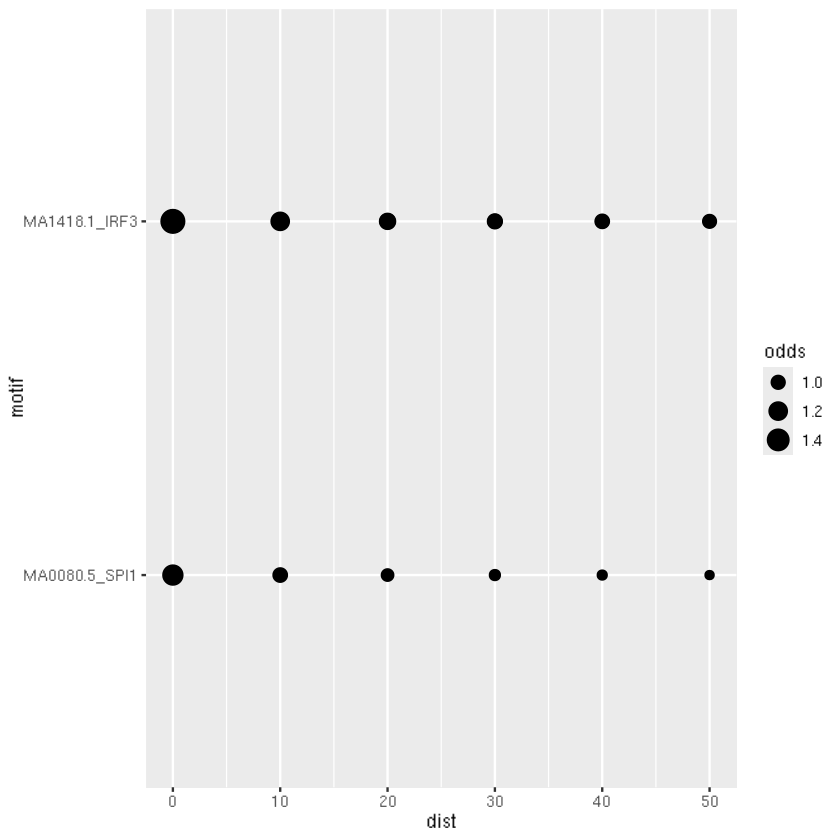

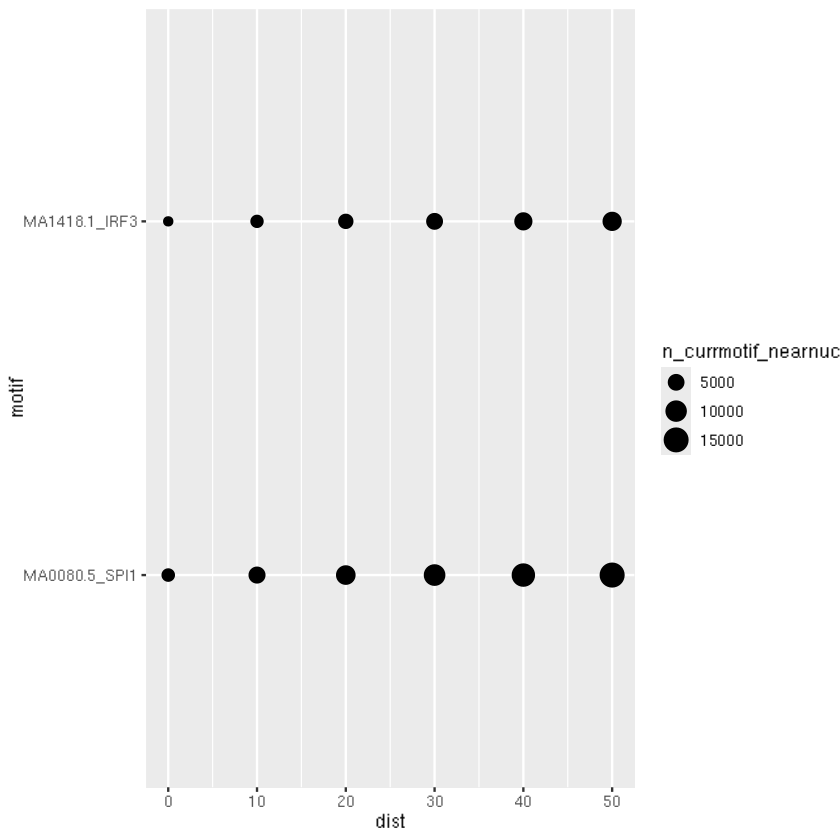

In [ ]:
ggplot(output, aes(x=dist, y=motif, size=odds)) + geom_point()
ggplot(output, aes(x=dist, y=motif, size=n_currmotif_nearnuc)) + geom_point()

### group by peak sensitivity group

In [ ]:
meta <- read.table(paste0(base_dir, "/output/02-atac/10/", TF,"_motif_containing_peak_meta.tsv"), row.names=1, sep="\t")
head(meta)

,sensitive,saturating,EC50,h,state,group
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
HEK293T_P3G8_SPI1_d075_peak_6,No,NA,NA,NA,open,open nonsensitive
HEK293T_P3A12_GFP_d100_peak_56,No,NA,NA,NA,open,open nonsensitive
HEK293T_P2E7_TCF3_d100_peak_25,Yes,Yes,2.635029e-05,7.0789829,NA,saturating sensitive
HEK293T_P2F7_TCF3_d100_peak_23b,Yes,Yes,3.527159e-09,0.1156643,NA,saturating sensitive
HEK293T_P3E2_KLF1_d100_peak_62,Yes,Yes,9.742721e-02,0.7991165,NA,saturating sensitive
HEK293T_P2E7_TCF3_d100_peak_29a,Yes,Yes,2.841933e-02,0.7163332,NA,saturating sensitive


In [ ]:
# read the consensus peak set to get the peak ranges
conspeaks <- read.table(paste0(base_dir, "/output/02-atac/01/consensus_peaks_HEK293T.bed"), sep="\t", 
                        col.names=c("seqname", "start", "end", "name", "score", "strand"))
conspeaks <- makeGRangesFromDataFrame(conspeaks, keep.extra.columns=T)
conspeaks

GRanges object with 608176 ranges and 2 metadata columns:
           seqnames              ranges strand |                   name
              <Rle>           <IRanges>  <Rle> |            <character>
       [1]     chr1          9954-10456      * | HEK293T_P3A12_GFP_d1..
       [2]     chr1       778479-778981      * | HEK293T_P3A12_GFP_d1..
       [3]     chr1       778996-779498      * | HEK293T_P3G8_SPI1_d0..
       [4]     chr1       779566-780068      * | HEK293T_P1B6_SP4_d00..
       [5]     chr1       826547-827049      * | HEK293T_P3G7_SPI1_d1..
       ...      ...                 ...    ... .                    ...
  [608172]     chrX 155644324-155644826      * | HEK293T_P3C3_KLF4_d0..
  [608173]     chrX 155656934-155657436      * | HEK293T_P3E2_KLF1_d1..
  [608174]     chrX 155657577-155658079      * | HEK293T_P3C3_KLF4_d0..
  [608175]     chrX 155662296-155662798      * | HEK293T_P3A12_GFP_d1..
  [608176]     chrX 155687335-155687837      * | HEK293T_P2D8_ALX4_d0..
      

In [19]:
# this take ~1min
output_fine <- list()
output_coarse <- list()

#suppressWarnings()
# iterate through motifs to test
#for (i in seq(1, length(motifs_to_test))){
# for (i in seq(1, 2)){
motifs_to_test <- c(motif_code_ls[TF])
for (i in seq(1, 1)){    
    message("----------------------")
    message(motifs_to_test[i])
    m_raw <- motifs[[motifs_to_test[i]]]
    
    for (g in meta$group %>% unique){
        peaknames_in_group <- meta[meta$group==g,] %>% rownames
        overlap <- findOverlaps(m_raw, conspeaks[conspeaks$name %in% peaknames_in_group])
        m <- m_raw[overlap@from %>% unique]

        # iterate through diff nucleosome position sets 
        for (j in seq(1, length(nucleo_ls))){
            message(paste0("> ", names(nucleo_ls)[j]))
            nuc <- nucleo_ls[[j]] %>% GRanges

            # get distances to nearest dyad center
            dist_to_nuc <- distanceToNearest(m, nuc)
            mcols(dist_to_nuc) <- cbind(mcols(dist_to_nuc), mcols(nuc[dist_to_nuc@to]))

            # fine: this only looks at motifs within 250bp of a nucleosome, bin 10bp
            breaks <- seq(0, 250, by = 10)

            dist <- cut(mcols(dist_to_nuc)$distance, breaks) 
            mcols(dist_to_nuc)$dist_bin <- dist
            df <- mcols(dist_to_nuc) %>% as.data.frame %>% dplyr::group_by(dist_bin) %>% dplyr::summarise(motif_count=n(), avg_occ_lower=mean(occ_lower), 
                                                                                avg_occ=mean(occ), avg_occ_upper=mean(occ_upper),
                                                                                avg_nread_121bp=mean(nread_121bp))
            df <- df[!is.na(df$dist_bin),]
            df$breaks <- str_split(str_split(as.character(df$dist_bin), ",", simplify=T)[,1],
                                    pattern='\\(', simplify=T)[,2] %>% as.numeric
            df$motif <- motifs_to_test[i]
            df$model <- names(nucleo_ls)[j]
            df$peak_group <- g
            output_fine <- c(output_fine, DataFrame(df)) 

            # coarse: this looks at motifs within 1000bp of a nucleosome, bin 40bp
            breaks <- seq(0, 1000, by = 40)

            dist <- cut(mcols(dist_to_nuc)$distance, breaks) 
            mcols(dist_to_nuc)$dist_bin <- dist
            df <- mcols(dist_to_nuc) %>% as.data.frame %>% dplyr::group_by(dist_bin) %>% dplyr::summarise(motif_count=n(), avg_occ_lower=mean(occ_lower), 
                                                                                avg_occ=mean(occ), avg_occ_upper=mean(occ_upper),
                                                                                avg_nread_121bp=mean(nread_121bp))
            df <- df[!is.na(df$dist_bin),]
            df$breaks <- str_split(str_split(as.character(df$dist_bin), ",", simplify=T)[,1],
                                    pattern='\\(', simplify=T)[,2] %>% as.numeric
            #df$motif <- motifs_to_test[i]
            df$motif <- motif_code_ls[TF]
            df$model <- names(nucleo_ls)[j]
            df$peak_group <- g
            output_coarse <- c(output_coarse, DataFrame(df)) 
        }
    }
    
}


----------------------

MA1112.2_NR4A1

> HEK293T_P1A12_GFP_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P2E2_NR4A1_d100

> HEK293T_P2E3_NR4A1_d075

> HEK293T_P2E4_NR4A1_d050

> HEK293T_P2E5_NR4A1_d025

> HEK293T_P2E6_NR4A1_d005

> HEK293T_P2F2_NR4A1_d100

> HEK293T_P2F3_NR4A1_d075

> HEK293T_P2F4_NR4A1_d050

> HEK293T_P2F5_NR4A1_d025

> HEK293T_P2F6_NR4A1_d005

> HEK293T_P1A12_GFP_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P2E2_NR4A1_d100

> HEK293T_P2E3_NR4A1_d075

> HEK293T_P2E4_NR4A1_d050

> HEK293T_P2E5_NR4A1_d025

> HEK293T_P2E6_NR4A1_d005

> HEK293T_P2F2_NR4A1_d100

> HEK293T_P2F3_NR4A1_d075

> HEK293T_P2F4_NR4A1_d050

> HEK293T_P2F5_NR4A1_d025

> HEK293T_P2F6_NR4A1_d005

> HEK293T_P1A12_GFP_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P2E2_NR4A1_d100

> HEK293T_P2E3_NR4A1_d075

> HEK293T_P2E4_NR4A1_d050

> HEK293T_P2E5_NR4A1_d025

> HEK293T_P2E6_NR4A1_d005

> HEK293T_P2F2_NR4A1_d100

> HEK293T_P2F3_NR4A1_d075

> HEK293T_P2F4_NR4A1_d050

> HEK293T_P2F5_NR4A1_d025

> HEK293T_P2F6_NR4A1_

In [20]:
output_fine <- do.call(rbind, output_fine)
output_coarse <- do.call(rbind, output_coarse)

saveRDS(output_fine, paste0(outdir, "/", TF, "_nucdist_bymodel_bysensgroup.rds"))
saveRDS(output_coarse, paste0(outdir, "/", TF, "_nucdist_bymodel_bysensgroup_coarse.rds"))

In [6]:
output_fine <- readRDS(paste0(outdir, "/", TF, "_nucdist_bymodel_bysensgroup.rds"))

In [7]:
output <- output_fine
suffix <- ""

# output <- output_coarse
# suffix <- "_coarse"

In [8]:
output$dose <- str_split(output$model, "_d", simplify=T)[,2] %>% as.numeric
output[grepl("GFP", output$model), "dose"] <- 0
# average replicates
output <- output %>% as.data.frame %>% group_by(motif, dose, breaks, peak_group) %>% 
            dplyr::summarise(motif_count=mean(motif_count),
                             avg_occ=mean(avg_occ),
                             avg_occ_lower=mean(avg_occ_lower),
                             avg_occ_upper=mean(avg_occ_upper),
                             avg_nread_121bp=mean(avg_nread_121bp)) %>% 
                             dplyr::mutate(countxocc=avg_occ*motif_count) %>%
                             as.data.frame

# 0 to 1 scale per dose per motif per group
for (m in unique(output$motif)){
    for (d in unique(output$dose)){
        for (g in unique(output$peak_group)){
            idx <- (output$dose==d) & (output$motif==m) & (output$peak_group==g)
            tmp <- scales::rescale(output[idx, "motif_count"])
            tmp2 <- scales::rescale(output[idx, "countxocc"])
            output[idx, "motif_count_scaled"] <- tmp 
            output[idx, "countxocc_scaled"] <- tmp2 
        }
    }
}
head(output)

`summarise()` has grouped output by 'motif', 'dose', 'breaks'. You can override
using the `.groups` argument.


,motif,dose,breaks,peak_group,motif_count,avg_occ,avg_occ_lower,avg_occ_upper,avg_nread_121bp,countxocc,motif_count_scaled,countxocc_scaled
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,MA0522.3_TCF3,0,0,closed nonsensitive,433.0,0.9855381,0.2913358,0.9977707,2.138608,426.73799,0.9413333,0.9361063
2,MA0522.3_TCF3,0,0,nonsaturating sensitive,37.0,0.8904875,0.3968774,0.9729654,6.080409,32.94804,0.7272727,0.6901478
3,MA0522.3_TCF3,0,0,open nonsensitive,683.0,0.9251268,0.4018752,0.9783915,5.453069,631.86163,1.0000000,1.0000000
4,MA0522.3_TCF3,0,0,saturating sensitive,472.5,0.9609361,0.3121721,0.9903952,3.208421,454.04232,0.9802198,0.9533061
5,MA0522.3_TCF3,0,10,closed nonsensitive,444.0,0.9877718,0.2869953,0.9983231,2.151173,438.57068,1.0000000,1.0000000
6,MA0522.3_TCF3,0,10,nonsaturating sensitive,46.0,0.9171086,0.3477239,0.9767846,4.826087,42.18700,1.0000000,1.0000000


In [9]:
m <- motif_code_ls[TF]
print(m)
subset <- output %>% as.data.frame %>% dplyr::filter(motif==m)
peak_group_levels <- c("saturating sensitive", "nonsaturating sensitive", "open nonsensitive", "closed nonsensitive")
dose_peakgroup_levels <- lapply(peak_group_levels, function(g){paste0(unique(subset$dose), "_", g)}) %>% unlist
subset$dose_peakgroup <- paste0(subset$dose, "_", subset$peak_group)

mat <- reshape2::dcast(subset, dose_peakgroup ~ breaks, value.var="motif_count_scaled") %>% column_to_rownames("dose_peakgroup") 
mat <- mat[dose_peakgroup_levels,]
ht1 <- Heatmap(mat,
        name=paste0("scaled motif counts\n",m ),
        column_title="distance to nearest dyad center (bp)",
        row_title="dose_peakgroup",
        row_split = rep(1:4, each = 6), # Split every 5 rows
        cluster_columns=F,
        cluster_rows=F)

mat <- reshape2::dcast(subset, dose_peakgroup ~ breaks, value.var="avg_occ") %>% column_to_rownames("dose_peakgroup") 
mat <- mat[dose_peakgroup_levels,]
ht2 <- Heatmap(mat,
        name=paste0("Nuc occ score\n",m ),
        column_title="distance to nearest dyad center (bp)",
        row_title="dose_peakgroup",
        row_split = rep(1:4, each = 6), # Split every 5 rows
        cluster_columns=F,
        cluster_rows=F)

mat <- reshape2::dcast(subset, dose_peakgroup ~ breaks, value.var="avg_occ_lower") %>% column_to_rownames("dose_peakgroup") 
mat <- mat[dose_peakgroup_levels,]
ht3 <- Heatmap(mat,
        name=paste0("Nuc occ score (lower)\n",m ),
        column_title="distance to nearest dyad center (bp)",
        row_title="dose_peakgroup",
        row_split = rep(1:4, each = 6), # Split every 5 rows
        cluster_columns=F,
        cluster_rows=F)

mat <- reshape2::dcast(subset, dose_peakgroup ~ breaks, value.var="avg_occ_upper") %>% column_to_rownames("dose_peakgroup") 
mat <- mat[dose_peakgroup_levels,]
ht4 <- Heatmap(mat,
        name=paste0("Nuc occ score (upper)\n",m ),
        column_title="distance to nearest dyad center (bp)",
        row_title="dose_peakgroup",
        row_split = rep(1:4, each = 6), # Split every 5 rows
        cluster_columns=F,
        cluster_rows=F)

mat <- reshape2::dcast(subset, dose_peakgroup ~ breaks, value.var="countxocc_scaled") %>% column_to_rownames("dose_peakgroup") 
mat <- mat[dose_peakgroup_levels,]
ht5 <- Heatmap(mat,
        name=paste0("scaled motif counts x occ score\n",m ),
        column_title="distance to nearest dyad center (bp)",
        row_title="dose_peakgroup",
        row_split = rep(1:4, each = 6), # Split every 5 rows
        cluster_columns=F,
        cluster_rows=F)

pdf(paste0(plotdir, "/", TF, "_models_",m,"_heatmap_dist_dyad_bysensgroup", suffix, ".pdf"), width=7, height=6)
draw(ht1)
draw(ht2)
draw(ht3)
draw(ht4)
draw(ht5)
dev.off()

           TCF3 
"MA0522.3_TCF3" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


png 
  2

### group by when a motif becomes a chrombpnet hit
Come back here after running scripts 14-16

In [ ]:
refdict = {"SPI1": "ETS_single__merged_pattern_0",
            # "ELF1": "ETS_single_1__merged_pattern_0",
            "ELF1": "ETS_single_2__merged_pattern_0",
            "KLF1": "SP.KLF_single_1__merged_pattern_0",
            "KLF4": "SP.KLF_single_1__merged_pattern_0",
            "ALX4": "ALX.HD__merged_pattern_0",
            "IRF4": "IRF_single__merged_pattern_0",
            "LEF1": "LEF_single__merged_pattern_0",
            "OCT4": "POU_single__merged_pattern_0",
            "SOX2": "SOX_single__merged_pattern_0",
            "SP4": "SP.KLF_single__merged_pattern_0",
            "TCF3": "bHLH_single__merged_pattern_0"}

In [ ]:
keyword <- refdict[TF]
meta <- read.table(paste0(base_dir, "/output/02-atac/16/", TF,"_", keyword, "_hit_dose.csv"), sep=",", header=T)
meta$group <- meta$hit_dose
meta <- makeGRangesFromDataFrame(meta, keep.extra.columns = T)
head(meta)

GRanges object with 6 ranges and 29 metadata columns:
      seqnames        ranges strand |         X start_untrimmed end_untrimmed
         <Rle>     <IRanges>  <Rle> | <integer>       <integer>     <integer>
  [1]     chr1 778914-778919      + |         0          778904        778934
  [2]     chr1 779902-779907      - |         1          779886        779916
  [3]     chr1 827335-827340      + |         2          827326        827356
  [4]     chr1 827513-827518      + |         3          827504        827534
  [5]     chr1 827764-827769      + |         4          827754        827784
  [6]     chr1 876632-876637      + |         5          876622        876652
                  motif_name hit_coefficient hit_correlation hit_importance
                 <character>       <numeric>       <numeric>      <numeric>
  [1] pos_patterns.ETS_sin..         1.44897        0.694037     0.00636286
  [2] pos_patterns.ETS_sin..        46.66339        0.856465     0.03464162
  [3] pos_patterns

In [ ]:
# this take ~1min
output_fine <- list()
output_coarse <- list()

#suppressWarnings()
# iterate through motifs to test
#for (i in seq(1, length(motifs_to_test))){
# for (i in seq(1, 2)){
motifs_to_test <- grep(keyword, motifs_to_test, value=T) # if chrombpnet hits
for (i in seq(1, 1)){    
    message("----------------------")
    message(motifs_to_test[i])
    m_raw <- motifs[[motifs_to_test[i]]]
    
    for (g in meta$group %>% unique){
        m <- meta[meta$group==g]

        # iterate through diff nucleosome position sets 
        for (j in seq(1, length(nucleo_ls))){
            message(paste0("> ", names(nucleo_ls)[j]))
            nuc <- nucleo_ls[[j]] %>% GRanges

            # get distances to nearest dyad center
            dist_to_nuc <- distanceToNearest(m, nuc)
            mcols(dist_to_nuc) <- cbind(mcols(dist_to_nuc), mcols(nuc[dist_to_nuc@to]))

            # fine: this only looks at motifs within 250bp of a nucleosome, bin 10bp
            breaks <- seq(0, 250, by = 10)

            dist <- cut(mcols(dist_to_nuc)$distance, breaks) 
            mcols(dist_to_nuc)$dist_bin <- dist
            df <- mcols(dist_to_nuc) %>% as.data.frame %>% dplyr::group_by(dist_bin) %>% dplyr::summarise(motif_count=n(), avg_occ_lower=mean(occ_lower), 
                                                                                avg_occ=mean(occ), avg_occ_upper=mean(occ_upper),
                                                                                avg_nread_121bp=mean(nread_121bp))
            df <- df[!is.na(df$dist_bin),]
            df$breaks <- str_split(str_split(as.character(df$dist_bin), ",", simplify=T)[,1],
                                    pattern='\\(', simplify=T)[,2] %>% as.numeric
            df$motif <- motifs_to_test[i]
            df$model <- names(nucleo_ls)[j]
            df$peak_group <- g
            output_fine <- c(output_fine, DataFrame(df)) 

            # coarse: this looks at motifs within 1000bp of a nucleosome, bin 40bp
            breaks <- seq(0, 1000, by = 40)

            dist <- cut(mcols(dist_to_nuc)$distance, breaks) 
            mcols(dist_to_nuc)$dist_bin <- dist
            df <- mcols(dist_to_nuc) %>% as.data.frame %>% dplyr::group_by(dist_bin) %>% dplyr::summarise(motif_count=n(), avg_occ_lower=mean(occ_lower), 
                                                                                avg_occ=mean(occ), avg_occ_upper=mean(occ_upper),
                                                                                avg_nread_121bp=mean(nread_121bp))
            df <- df[!is.na(df$dist_bin),]
            df$breaks <- str_split(str_split(as.character(df$dist_bin), ",", simplify=T)[,1],
                                    pattern='\\(', simplify=T)[,2] %>% as.numeric
            #df$motif <- motifs_to_test[i]
            df$motif <- motif_code_ls[TF]
            df$model <- names(nucleo_ls)[j]
            df$peak_group <- g
            output_coarse <- c(output_coarse, DataFrame(df)) 
        }
    }
    
}


In [ ]:
output_fine <- do.call(rbind, output_fine)
output_coarse <- do.call(rbind, output_coarse)

saveRDS(output_fine, paste0(outdir, "/", TF, "_", keyword, "_nucdist_bymodel_byhitdosegroup.rds"))
saveRDS(output_coarse, paste0(outdir, "/", TF, "_", keyword, "_nucdist_bymodel_byhitdosegroup_coarse.rds"))

In [14]:
output <- output_fine
suffix <- ""

# output <- output_coarse
# suffix <- "_coarse"

In [13]:
output$dose <- str_split(output$model, "_d", simplify=T)[,2] %>% as.numeric
output[grepl("GFP", output$model), "dose"] <- 0
# average replicates
output <- output %>% as.data.frame %>% group_by(motif, dose, breaks, peak_group) %>% 
            dplyr::summarise(motif_count=mean(motif_count),
                             avg_occ=mean(avg_occ),
                             avg_occ_lower=mean(avg_occ_lower),
                             avg_occ_upper=mean(avg_occ_upper),
                             avg_nread_121bp=mean(avg_nread_121bp)) %>% 
                             dplyr::mutate(countxocc=avg_occ*motif_count) %>%
                             as.data.frame

# 0 to 1 scale per dose per motif per group
for (m in unique(output$motif)){
    for (d in unique(output$dose)){
        for (g in unique(output$peak_group)){
            idx <- (output$dose==d) & (output$motif==m) & (output$peak_group==g)
            tmp <- scales::rescale(output[idx, "motif_count"])
            tmp2 <- scales::rescale(output[idx, "countxocc"])
            output[idx, "motif_count_scaled"] <- tmp 
            output[idx, "countxocc_scaled"] <- tmp2 
        }
    }
}
head(output)

`summarise()` has grouped output by 'motif', 'dose', 'breaks'. You can override
using the `.groups` argument.


,motif,dose,breaks,peak_group,motif_count,avg_occ,avg_occ_lower,avg_occ_upper,avg_nread_121bp,countxocc,motif_count_scaled,countxocc_scaled
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,pos_patterns.ETS_single,0,0,d005,3094.5,0.9530089,0.3349380,0.9855260,4.004289,2949.086,0.9505011,0.9453023
2,pos_patterns.ETS_single,0,0,d025,1902.5,0.9663011,0.3375557,0.9919472,3.357493,1838.388,0.9624703,0.9709024
3,pos_patterns.ETS_single,0,0,d050,1155.5,0.9602663,0.3395488,0.9894536,3.666886,1109.588,0.8827292,0.8750345
4,pos_patterns.ETS_single,0,0,d075,1111.0,0.9477351,0.3385173,0.9840953,4.056771,1052.934,0.9531250,0.9495292
5,pos_patterns.ETS_single,0,0,d100,4165.0,0.9544880,0.3488342,0.9881136,3.947634,3975.443,0.9672131,0.9683397
6,pos_patterns.ETS_single,0,10,d005,3081.5,0.9540103,0.3365619,0.9863176,3.890162,2939.783,0.9426055,0.9392598


In [ ]:
print(m)
subset <- output %>% as.data.frame %>% dplyr::filter(motif==m)
peak_group_levels <- c("d005", "d025", "d050", "d075", "d100")
dose_peakgroup_levels <- lapply(peak_group_levels, function(g){paste0(unique(subset$dose), "_", g)}) %>% unlist
subset$dose_peakgroup <- paste0(subset$dose, "_", subset$peak_group)

mat <- reshape2::dcast(subset, dose_peakgroup ~ breaks, value.var="motif_count_scaled") %>% column_to_rownames("dose_peakgroup") 
mat <- mat[dose_peakgroup_levels,]
ht1 <- Heatmap(mat,
        name=paste0("scaled motif counts\n",m ),
        column_title="distance to nearest dyad center (bp)",
        row_title="dose_peakgroup",
        row_split = rep(1:length(peak_group_levels), each = 6), # Split every 5 rows
        cluster_columns=F,
        cluster_rows=F)

mat <- reshape2::dcast(subset, dose_peakgroup ~ breaks, value.var="avg_occ") %>% column_to_rownames("dose_peakgroup") 
mat <- mat[dose_peakgroup_levels,]
ht2 <- Heatmap(mat,
        name=paste0("Nuc occ score\n",m ),
        column_title="distance to nearest dyad center (bp)",
        row_title="dose_peakgroup",
        row_split = rep(1:length(peak_group_levels), each = 6), # Split every 5 rows
        cluster_columns=F,
        cluster_rows=F)

mat <- reshape2::dcast(subset, dose_peakgroup ~ breaks, value.var="avg_occ_lower") %>% column_to_rownames("dose_peakgroup") 
mat <- mat[dose_peakgroup_levels,]
ht3 <- Heatmap(mat,
        name=paste0("Nuc occ score (lower)\n",m ),
        column_title="distance to nearest dyad center (bp)",
        row_title="dose_peakgroup",
        row_split = rep(1:length(peak_group_levels), each = 6), # Split every 5 rows
        cluster_columns=F,
        cluster_rows=F)

mat <- reshape2::dcast(subset, dose_peakgroup ~ breaks, value.var="avg_occ_upper") %>% column_to_rownames("dose_peakgroup") 
mat <- mat[dose_peakgroup_levels,]
ht4 <- Heatmap(mat,
        name=paste0("Nuc occ score (upper)\n",m ),
        column_title="distance to nearest dyad center (bp)",
        row_title="dose_peakgroup",
        row_split = rep(1:length(peak_group_levels), each = 6), # Split every 5 rows
        cluster_columns=F,
        cluster_rows=F)

mat <- reshape2::dcast(subset, dose_peakgroup ~ breaks, value.var="countxocc_scaled") %>% column_to_rownames("dose_peakgroup") 
mat <- mat[dose_peakgroup_levels,]
ht5 <- Heatmap(mat,
        name=paste0("scaled motif counts x occ score\n",m ),
        column_title="distance to nearest dyad center (bp)",
        row_title="dose_peakgroup",
        row_split = rep(1:length(peak_group_levels), each = 6), # Split every 5 rows
        cluster_columns=F,
        cluster_rows=F)

pdf(paste0(plotdir, "/", TF, ,"_", keyword, "_models_",m,"_heatmap_dist_dyad_byhitdosegroup", suffix, ".pdf"), width=7, height=6)
draw(ht1)
draw(ht2)
draw(ht3)
draw(ht4)
draw(ht5)
dev.off()

[1] "pos_patterns.ETS_single"


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


png 
  2

#### try multiple nearest dyads

In [10]:
# unexported find K nearest neighbor function from GenomicRanges
# https://github.com/Bioconductor/GenomicRanges/blob/badfd17d5c960db3244cf1a2252eb035c57fe102/R/nearest-methods.R#L479
findKNN <- function(query, subject, k=5L, ignore.overlaps = FALSE,
                    ignore.strand = FALSE)
{
    seqlevels(subject) <- seqlevels(query)
    
    starts <- with(subject, GRanges(seqnames, IRanges(start, width=1L), strand))
    ends <- with(subject, GRanges(seqnames, IRanges(end, width=1L), strand))

    if (ignore.strand) {
        starts <- unstrand(starts)
        ends <- unstrand(ends)
    }
    
    start_ord <- order(starts)
    end_ord <- order(ends)

    starts <- starts[start_ord]
    ends <- ends[end_ord]

    phits <- precede(query, starts, ignore.strand=ignore.strand)
    fhits <- follow(query, ends, ignore.strand=ignore.strand)

    if (!ignore.strand) {
        exchange <- decode(strand(query) == "-")
        tmp <- phits[exchange]
        phits[exchange] <- fhits[exchange]
        fhits[exchange] <- tmp
    }

    findPart <- function(x, w) {
        S4Vectors:::findIntervalAndStartFromWidth(x, w)[["interval"]]
    }
    
    if (!ignore.strand) {
        b <- width(disjoin(c(ranges(seqnames(starts)), ranges(strand(starts)))))
    } else {
        b <- runLength(seqnames(starts))
    }
    
    seqends <- end(seqnames(starts))[findPart(phits, b)]
    phits[is.na(phits)] <- 1L
    seqends[is.na(seqends)] <- 0L
    pwindows <- restrict(IRanges(phits, width = k), end=seqends)

    seqstarts <- start(seqnames(ends))[findPart(fhits, b)]
    seqstarts[is.na(seqstarts)] <- 1L
    fhits[is.na(fhits)] <- 0L
    fwindows <- restrict(IRanges(end=fhits, width = k), seqstarts)
    
    dist <- pc(extractList(start(starts), pwindows) - end(query),
               end(query) - extractList(end(ends), fwindows))

    ans <- pc(extractList(start_ord, pwindows), extractList(end_ord, fwindows))

    if (!ignore.overlaps) {
        hits <- findOverlaps(query, subject, ignore.strand=ignore.strand)
        hitsList <- as(hits, "List")
        dist <- pc(dist, relist(rep(0L, length(hits)), hitsList))
        ans <- pc(ans, hitsList)
    }

    ans[heads(order(dist), k)]
}

In [62]:
lapply(1:length(m), function(i){rep(i, k_nearest)}) %>% unlist

[1]     1     1     1     1     1     2     2     2     2     2     3     3
   [13]     3     3     3     4     4     4     4     4     5     5     5     5
   [25]     5     6     6     6     6     6     7     7     7     7     7     8
   [37]     8     8     8     8     9     9     9     9     9    10    10    10
   [49]    10    10    11    11    11    11    11    12    12    12    12    12
   [61]    13    13    13    13    13    14    14    14    14    14    15    15
   [73]    15    15    15    16    16    16    16    16    17    17    17    17
   [85]    17    18    18    18    18    18    19    19    19    19    19    20
   [97]    20    20    20    20    21    21    21    21    21    22    22    22
  [109]    22    22    23    23    23    23    23    24    24    24    24    24
  [121]    25    25    25    25    25    26    26    26    26    26    27    27
  [133]    27    27    27    28    28    28    28    28    29    29    29    29
  [145]    29    30    30    30    30    30    31    31    31    31    31    32
  [157]    32    32    32    32    33    33    33    33    33    34    34    34
  [169]    34    34    35    35    35    35    35    36    36    36    36    36
  [181]    37    37    37    37    37    38    38    38    38    38    39    39
  [193]    39    39    39    40    40    40    40    40    41    41    41    41
  [205]    41    42    42    42    42    42    43    43    43    43    43    44
  [217]    44    44    44    44    45    45    45    45    45    46    46    46
  [229]    46    46    47    47    47    47    47    48    48    48    48    48
  [241]    49    49    49    49    49    50    50    50    50    50    51    51
  [253]    51    51    51    52    52    52    52    52    53    53    53    53
  [265]    53    54    54    54    54    54    55    55    55    55    55    56
  [277]    56    56    56    56    57    57    57    57    57    58    58    58
  [289]    58    58    59    59    59    59    59    60    60    60    60    60
  [301]    61    61    61    61    61    62    62    62    62    62    63    63
  [313]    63    63    63    64    64    64    64    64    65    65    65    65
  [325]    65    66    66    66    66    66    67    67    67    67    67    68
  [337]    68    68    68    68    69    69    69    69    69    70    70    70
  [349]    70    70    71    71    71    71    71    72    72    72    72    72
  [361]    73    73    73    73    73    74    74    74    74    74    75    75
  [373]    75    75    75    76    76    76    76    76    77    77    77    77
  [385]    77    78    78    78    78    78    79    79    79    79    79    80
  [397]    80    80    80    80    81    81    81    81    81    82    82    82
  [409]    82    82    83    83    83    83    83    84    84    84    84    84
  [421]    85    85    85    85    85    86    86    86    86    86    87    87
  [433]    87    87    87    88    88    88    88    88    89    89    89    89
  [445]    89    90    90    90    90    90    91    91    91    91    91    92
  [457]    92    92    92    92    93    93    93    93    93    94    94    94
  [469]    94    94    95    95    95    95    95    96    96    96    96    96
  [481]    97    97    97    97    97    98    98    98    98    98    99    99
  [493]    99    99    99   100   100   100   100   100   101   101   101   101
  [505]   101   102   102   102   102   102   103   103   103   103   103   104
  [517]   104   104   104   104   105   105   105   105   105   106   106   106
  [529]   106   106   107   107   107   107   107   108   108   108   108   108
  [541]   109   109   109   109   109   110   110   110   110   110   111   111
  [553]   111   111   111   112   112   112   112   112   113   113   113   113
  [565]   113   114   114   114   114   114   115   115   115   115   115   116
  [577]   116   116   116   116   117   117   117   117   117   118   118   118
  [589]   118   118   119   119   119   119   119   120   120   120   120   120
  [6

In [ ]:
# this take ~1min
output_fine <- list()
output_coarse <- list()

#suppressWarnings()
# iterate through motifs to test
#for (i in seq(1, length(motifs_to_test))){
# for (i in seq(1, 2)){
# motifs_to_test <- grep(keyword, motifs_to_test, value=T) # if chrombpnet hits
motifs_to_test <- grep("CTCF", motifs_to_test, value=T) # try CTCF

for (i in seq(1, 1)){    
    message("----------------------")
    message(motifs_to_test[i])
    m_raw <- motifs[[motifs_to_test[i]]]
    
    # for (g in meta$group %>% unique){
    #     m <- meta[meta$group==g]
    for (g in c(1)){ # test code for CTCF only
        m <- m_raw # test code for CTCF only
    
        # iterate through diff nucleosome position sets 
        for (j in seq(1, length(nucleo_ls))){
            message(paste0("> ", names(nucleo_ls)[j]))
            nuc <- nucleo_ls[[j]] %>% GRanges

            # get distances to k nearest dyad center
            k_nearest <- 5
            knn <- findKNN(m, nuc, k=k_nearest, ignore.strand=TRUE)

            dist_to_nuc <- cbind.data.frame((extractList(start(nuc), knn) - start(m)) %>% unlist %>% abs,
                                        rep(1:k_nearest, length(m)),
                                        lapply(1:length(m), function(i){rep(i, k_nearest)}) %>% unlist,
                                        nuc$occ[knn %>% unlist], 
                                        nuc$occ_lower[knn %>% unlist], 
                                        nuc$occ_upper[knn %>% unlist], 
                                        nuc$nread_121bp[knn %>% unlist] 
                                        )
            names(dist_to_nuc) <- c("distance",
                                "k",
                                "motif_idx",
                                "occ", 
                                "occ_lower",
                                "occ_upper",
                                "nread_121bp")

            # fine: this only looks at motifs within 250bp of a nucleosome, bin 10bp
            breaks <- seq(0, 250, by = 10)

            dist <- cut(dist_to_nuc$distance, breaks) 
            dist_to_nuc$dist_bin <- dist
            df <- dist_to_nuc %>% as.data.frame %>% dplyr::group_by(dist_bin) %>% dplyr::summarise(motif_count=n(), avg_occ_lower=mean(occ_lower), 
                                                                                avg_occ=mean(occ), avg_occ_upper=mean(occ_upper),
                                                                                avg_nread_121bp=mean(nread_121bp))
            df <- df[!is.na(df$dist_bin),]
            df$breaks <- str_split(str_split(as.character(df$dist_bin), ",", simplify=T)[,1],
                                    pattern='\\(', simplify=T)[,2] %>% as.numeric
            df$motif <- motifs_to_test[i]
            df$model <- names(nucleo_ls)[j]
            df$peak_group <- g
            output_fine <- c(output_fine, DataFrame(df)) 

            # coarse: this looks at motifs within 1000bp of a nucleosome, bin 40bp
            breaks <- seq(0, 1000, by = 40)

            dist <- cut(dist_to_nuc$distance, breaks) 
            dist_to_nuc$dist_bin <- dist
            df <- dist_to_nuc %>% as.data.frame %>% dplyr::group_by(dist_bin) %>% dplyr::summarise(motif_count=n(), avg_occ_lower=mean(occ_lower), 
                                                                                avg_occ=mean(occ), avg_occ_upper=mean(occ_upper),
                                                                                avg_nread_121bp=mean(nread_121bp))
            df <- df[!is.na(df$dist_bin),]
            df$breaks <- str_split(str_split(as.character(df$dist_bin), ",", simplify=T)[,1],
                                    pattern='\\(', simplify=T)[,2] %>% as.numeric
            df$motif <- motifs_to_test[i]
            df$model <- names(nucleo_ls)[j]
            df$peak_group <- g
            output_coarse <- c(output_coarse, DataFrame(df)) 
        }
    }
    
}


----------------------

pos_patterns.CTCF

> HEK293T_P1A12_GFP_d100

> HEK293T_P3E11_SPI1_d005

> HEK293T_P3E10_SPI1_d025

> HEK293T_P3E9_SPI1_d050

> HEK293T_P3E8_SPI1_d075

> HEK293T_P3E7_SPI1_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P3G11_SPI1_d005

> HEK293T_P3G10_SPI1_d025

> HEK293T_P3G9_SPI1_d050

> HEK293T_P3G8_SPI1_d075

> HEK293T_P3G7_SPI1_d100



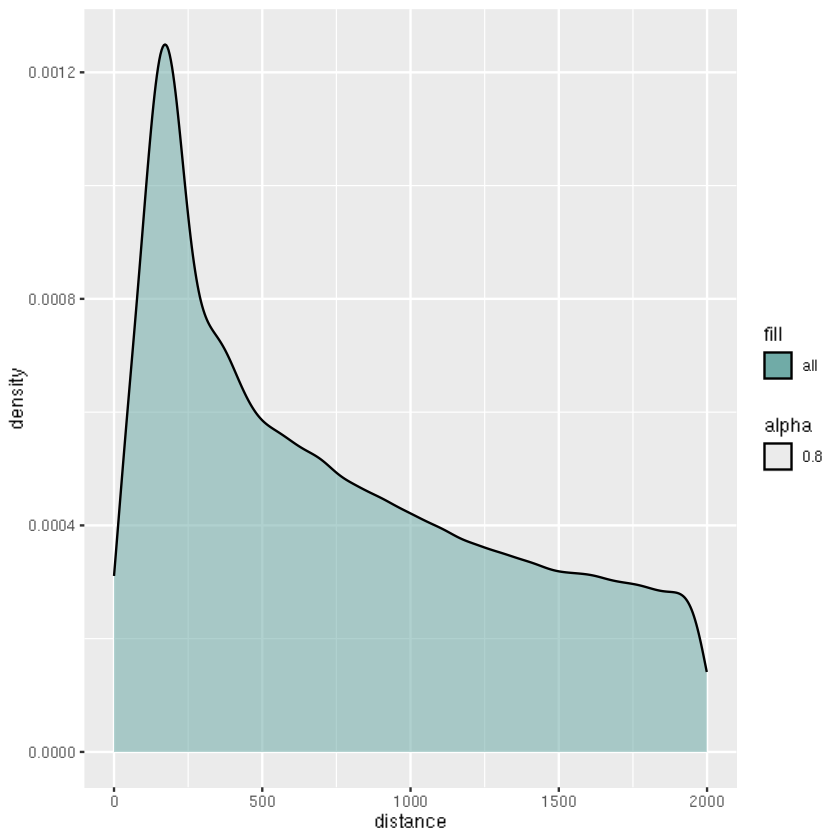

In [83]:
ggplot(dist_to_nuc %>% dplyr::filter(distance<2000), aes(x=distance, fill="all", alpha=0.8)) + 
geom_density() + scale_fill_manual(values=c("#70aba7"))

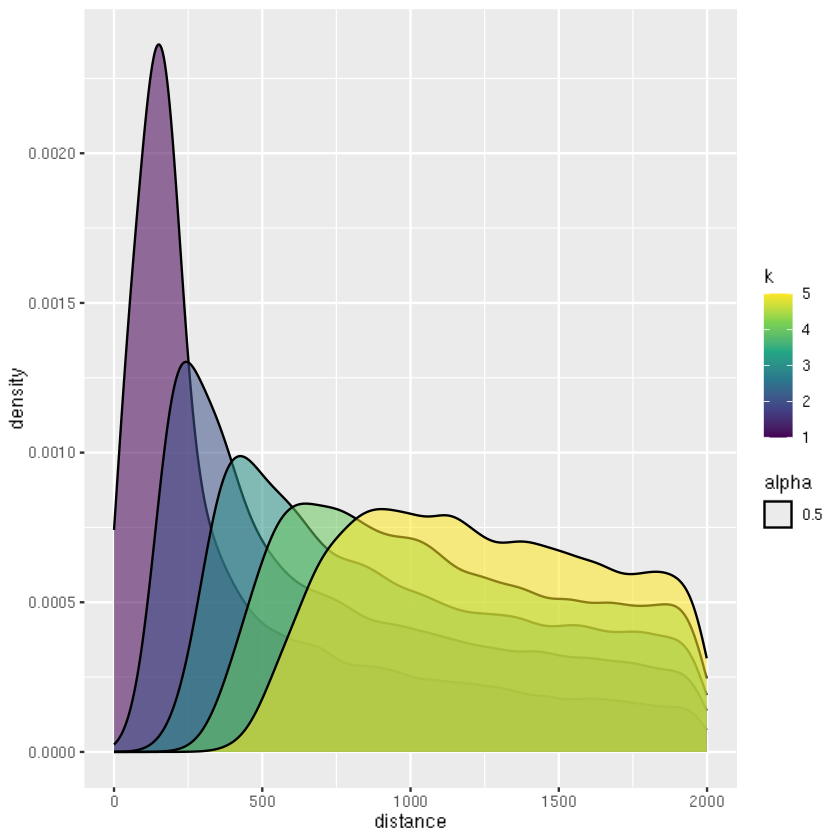

In [59]:
ggplot(dist_to_nuc %>% dplyr::filter(distance<2000), aes(group=k,x=distance, fill=k, alpha=0.5)) + 
geom_density() + scale_fill_viridis_c()

In [139]:
# try looking at only motifs that have 2 or more adjacent nucleosomes
tmp <- dist_to_nuc %>% dplyr::filter(distance<2000)
tmp <- tmp[tmp$motif_idx %in% which(table(tmp %>% dplyr::select(motif_idx))>=2),]

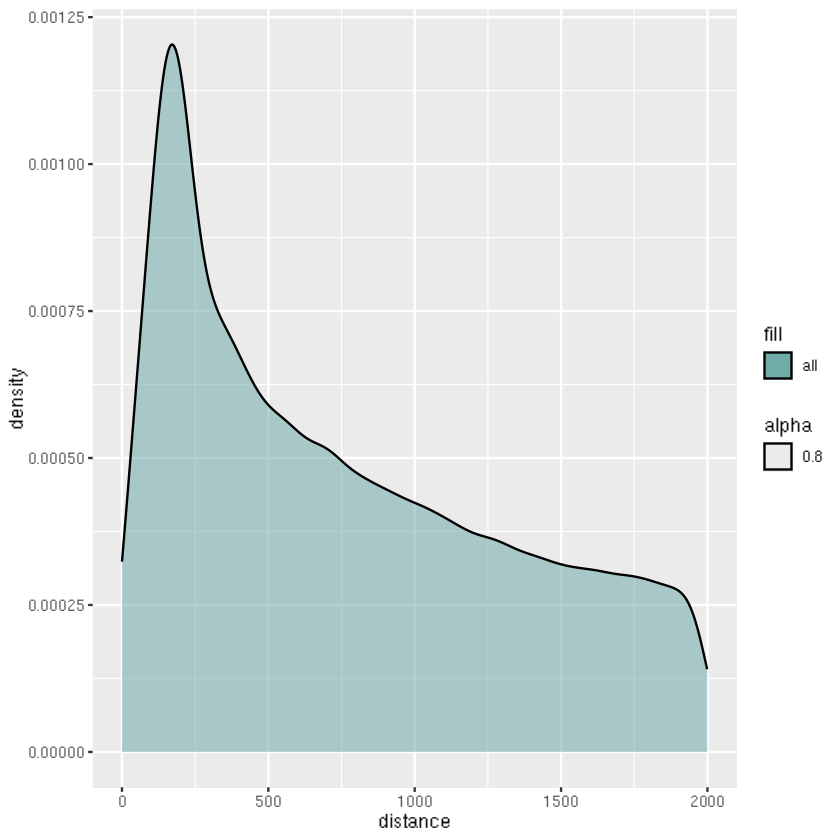

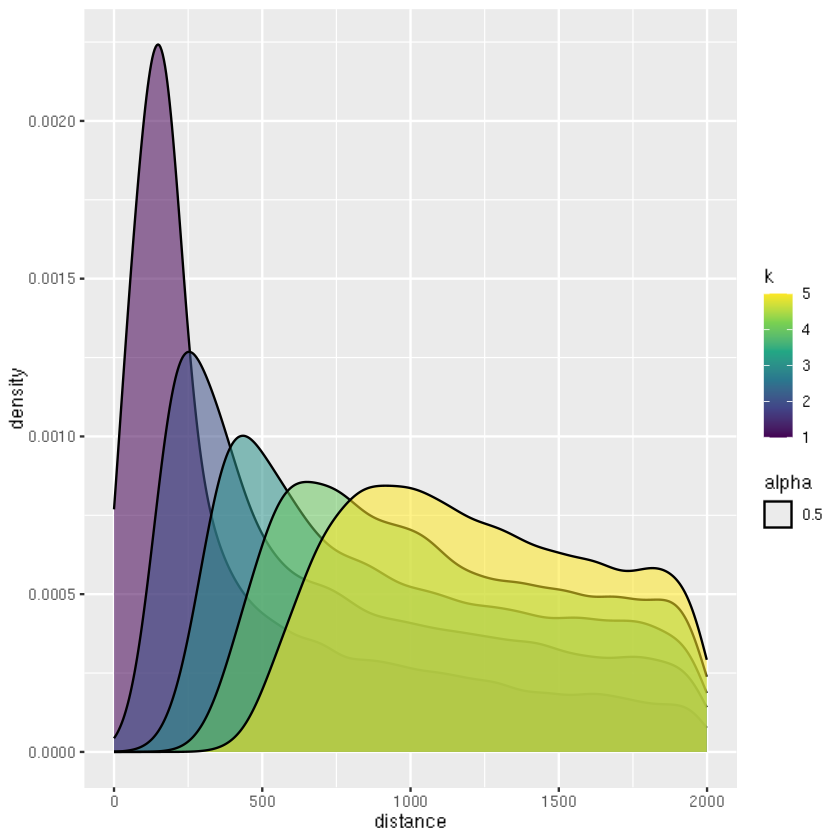

In [140]:
ggplot(tmp, aes(x=distance, fill="all", alpha=0.8)) + geom_density() + scale_fill_manual(values=c("#70aba7"))

ggplot(tmp, aes(group=k,x=distance, fill=k, alpha=0.5)) + geom_density() + scale_fill_viridis_c()


In [ ]:
output_fine <- do.call(rbind, output_fine)
output_coarse <- do.call(rbind, output_coarse)

# saveRDS(output_fine, paste0(outdir, "/", TF, "_", keyword, "_nucdist_multipledyad_bymodel_byhitdosegroup.rds"))
# saveRDS(output_coarse, paste0(outdir, "/", TF, "_", keyword, "_nucdist_multipledyad_bymodel_byhitdosegroup_coarse.rds"))

In [114]:
# output <- output_fine
# suffix <- ""

output <- output_coarse
suffix <- "_coarse"

In [115]:
output$dose <- str_split(output$model, "_d", simplify=T)[,2] %>% as.numeric
output[grepl("GFP", output$model), "dose"] <- 0
# average replicates
output <- output %>% as.data.frame %>% group_by(motif, dose, breaks, peak_group) %>% 
            dplyr::summarise(motif_count=mean(motif_count),
                             avg_occ=mean(avg_occ),
                             avg_occ_lower=mean(avg_occ_lower),
                             avg_occ_upper=mean(avg_occ_upper),
                             avg_nread_121bp=mean(avg_nread_121bp)) %>% 
                             dplyr::mutate(countxocc=avg_occ*motif_count) %>%
                             as.data.frame

# 0 to 1 scale per dose per motif per group
for (m in unique(output$motif)){
    for (d in unique(output$dose)){
        for (g in unique(output$peak_group)){
            idx <- (output$dose==d) & (output$motif==m) & (output$peak_group==g)
            tmp <- scales::rescale(output[idx, "motif_count"])
            tmp2 <- scales::rescale(output[idx, "countxocc"])
            output[idx, "motif_count_scaled"] <- tmp 
            output[idx, "countxocc_scaled"] <- tmp2 
        }
    }
}
head(output)

`summarise()` has grouped output by 'motif', 'dose', 'breaks'. You can override
using the `.groups` argument.


,motif,dose,breaks,peak_group,motif_count,avg_occ,avg_occ_lower,avg_occ_upper,avg_nread_121bp,countxocc,motif_count_scaled,countxocc_scaled
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,pos_patterns.ETS_single,0,0,d005,12417.0,0.9541910,0.3361877,0.9864250,3.883036,11848.190,0.8947500,0.8963517
2,pos_patterns.ETS_single,0,0,d025,7610.5,0.9641645,0.3362885,0.9914887,3.352217,7337.774,0.9369068,0.9308105
3,pos_patterns.ETS_single,0,0,d050,4751.0,0.9617379,0.3442846,0.9901060,3.655534,4569.217,1.0000000,1.0000000
4,pos_patterns.ETS_single,0,0,d075,4442.0,0.9541175,0.3401685,0.9870312,3.864250,4238.190,0.9030108,0.9080073
5,pos_patterns.ETS_single,0,0,d100,16656.0,0.9537181,0.3479174,0.9873636,3.953244,15885.128,0.9580578,0.9570409
6,pos_patterns.ETS_single,0,40,d005,12509.0,0.9516886,0.3417362,0.9856845,3.998376,11904.673,0.9100833,0.9064187


In [ ]:
print(m)
subset <- output %>% as.data.frame %>% dplyr::filter(motif==m)
peak_group_levels <- c("d005", "d025", "d050", "d075", "d100")
dose_peakgroup_levels <- lapply(peak_group_levels, function(g){paste0(unique(subset$dose), "_", g)}) %>% unlist
subset$dose_peakgroup <- paste0(subset$dose, "_", subset$peak_group)

mat <- reshape2::dcast(subset, dose_peakgroup ~ breaks, value.var="motif_count_scaled") %>% column_to_rownames("dose_peakgroup") 
mat <- mat[dose_peakgroup_levels,]
ht1 <- Heatmap(mat,
        name=paste0("scaled motif counts\n",m ),
        column_title="distance to nearest dyad center (bp)",
        row_title="dose_peakgroup",
        row_split = rep(1:length(peak_group_levels), each = 6), # Split every 5 rows
        cluster_columns=F,
        cluster_rows=F)

mat <- reshape2::dcast(subset, dose_peakgroup ~ breaks, value.var="avg_occ") %>% column_to_rownames("dose_peakgroup") 
mat <- mat[dose_peakgroup_levels,]
ht2 <- Heatmap(mat,
        name=paste0("Nuc occ score\n",m ),
        column_title="distance to nearest dyad center (bp)",
        row_title="dose_peakgroup",
        row_split = rep(1:length(peak_group_levels), each = 6), # Split every 5 rows
        cluster_columns=F,
        cluster_rows=F)

mat <- reshape2::dcast(subset, dose_peakgroup ~ breaks, value.var="avg_occ_lower") %>% column_to_rownames("dose_peakgroup") 
mat <- mat[dose_peakgroup_levels,]
ht3 <- Heatmap(mat,
        name=paste0("Nuc occ score (lower)\n",m ),
        column_title="distance to nearest dyad center (bp)",
        row_title="dose_peakgroup",
        row_split = rep(1:length(peak_group_levels), each = 6), # Split every 5 rows
        cluster_columns=F,
        cluster_rows=F)

mat <- reshape2::dcast(subset, dose_peakgroup ~ breaks, value.var="avg_occ_upper") %>% column_to_rownames("dose_peakgroup") 
mat <- mat[dose_peakgroup_levels,]
ht4 <- Heatmap(mat,
        name=paste0("Nuc occ score (upper)\n",m ),
        column_title="distance to nearest dyad center (bp)",
        row_title="dose_peakgroup",
        row_split = rep(1:length(peak_group_levels), each = 6), # Split every 5 rows
        cluster_columns=F,
        cluster_rows=F)

mat <- reshape2::dcast(subset, dose_peakgroup ~ breaks, value.var="countxocc_scaled") %>% column_to_rownames("dose_peakgroup") 
mat <- mat[dose_peakgroup_levels,]
ht5 <- Heatmap(mat,
        name=paste0("scaled motif counts x occ score\n",m ),
        column_title="distance to nearest dyad center (bp)",
        row_title="dose_peakgroup",
        row_split = rep(1:length(peak_group_levels), each = 6), # Split every 5 rows
        cluster_columns=F,
        cluster_rows=F)

pdf(paste0(plotdir, "/", TF, "_", keyword, "_models_",m,"_heatmap_dist_multipledyad_byhitdosegroup", suffix, ".pdf"), width=7, height=6)
draw(ht1)
draw(ht2)
draw(ht3)
draw(ht4)
draw(ht5)
dev.off()

[1] "pos_patterns.ETS_single"


Warning message:
“The input is a data frame, convert it to a matrix.”


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


png 
  2

# all TFs

## inputs

In [ ]:
get_nucleo <- function(TF, base_dir, valid_chr){
    # get samples -------------
    if (TF=="SPI1"){
        sample_ls <- c("HEK293T_P1A12_GFP_d100", "HEK293T_P3E11_SPI1_d005", "HEK293T_P3E10_SPI1_d025", "HEK293T_P3E9_SPI1_d050", "HEK293T_P3E8_SPI1_d075", "HEK293T_P3E7_SPI1_d100",
                    "HEK293T_P1B12_GFP_d100", "HEK293T_P3G11_SPI1_d005", "HEK293T_P3G10_SPI1_d025", "HEK293T_P3G9_SPI1_d050", "HEK293T_P3G8_SPI1_d075", "HEK293T_P3G7_SPI1_d100")
    } else{
        if (TF=="KLF1"){
            sample_ls <- c("HEK293T_P1A12_GFP_d100", "HEK293T_P3H6_KLF1_d005", "HEK293T_P3H5_KLF1_d025", "HEK293T_P3H4_KLF1_d050", "HEK293T_P3H3_KLF1_d075", "HEK293T_P3H2_KLF1_d100",
                        "HEK293T_P1B12_GFP_d100", "HEK293T_P3E6_KLF1_d005", "HEK293T_P3E5_KLF1_d025", "HEK293T_P3E4_KLF1_d050", "HEK293T_P3E3_KLF1_d075", "HEK293T_P3E2_KLF1_d100")
        } else{
            sample_ls <- c("HEK293T_P1A12_GFP_d100", "HEK293T_P1B12_GFP_d100", basename(Sys.glob(paste0(base_dir, "/output/02-atac/12/HEK293T*", TF, "*"))))
        }
    }
    print(sample_ls)

    # get all nucleosome calls -------------
    nucleo_ls <- list()
    for (sample in sample_ls){
        tmp <- read_tsv(paste0(base_dir, "/output/02-atac/12/", sample, "/", sample, ".occpeaks.bed.gz"), 
                        col_names=c("seqnames", "0-start", "start", "occ", "occ_lower", "occ_upper", "nread_121bp"), show_col_types = F) %>% dplyr::filter(seqnames %in% valid_chr)
        tmp$end <- tmp$start + 1
        nucleo_ls[[sample]] <- tmp
    }
    return(nucleo_ls)
}


In [ ]:
method <- 2 # 1 or 2, 1 uses just the JASPAR motif, 2 uses chrombpnet motif hits
base_dir <- "../../"
motif_pos_file <- paste0(base_dir, "/output/02-atac/03/motif.scores.JASPAR2020.pos.rds")
valid_chr <- paste0("chr", c(as.character(1:22), "X"))
outdir <- paste0(base_dir, "/output/02-atac/13/")
plotdir <- paste0(base_dir, "/output/02-atac/13/")
dir.create(outdir, showWarnings=F)
dir.create(plotdir, showWarnings=F)

jaspar_motif_code_ls <- c("ALX4"="MA0681.2_PHOX2B",
                   "ELF1"="MA0473.3_ELF1",
                   "IRF4"="MA1419.1_IRF4",
                   "KLF1"="MA0039.4_KLF4",
                   "KLF4"="MA0039.4_KLF4",
                   "LEF1"="MA0768.1_LEF1",
                #    "NR4A1"="MA1112.2_NR4A1",
                   "OCT4"="MA1115.1_POU5F1",
                #    "PRDM1"="MA0508.3_PRDM1",
                   "SOX2"="MA0143.4_SOX2",
                   "SP4"="MA0685.1_SP4",
                   "SPI1"="MA0080.5_SPI1",
                   "TCF3"="MA0522.3_TCF3")

chrombpnet_motif_code_ls <- c("ALX4"="pos_patterns.ALX.HD",
                   "ELF1"="pos_patterns.ETS_single_2",
                   "IRF4"="pos_patterns.IRF_single",
                   "KLF1"="pos_patterns.SP.KLF_single_1",
                #    "KLF4"="pos_patterns.SP.KLF_single_1",
                   "LEF1"="pos_patterns.LEF_single",
                   "OCT4"="pos_patterns.POU_single",
                   "SOX2"="pos_patterns.SOX_single",
                   "SP4"="pos_patterns.SP.KLF_single",
                   "SPI1"="pos_patterns.ETS_single",
                   "TCF3"="pos_patterns.bHLH_single")

stopifnot((method==1) | (method==2))
if (method==1){
    motif_code_ls <- jaspar_motif_code_ls
    suffix <- ""
} else{
    motif_code_ls <- chrombpnet_motif_code_ls
    suffix <- "_chrombphits"
}

In [ ]:
# read motif matchr results
motifs_raw <- readRDS(motif_pos_file)
motifs <- list()
for (n in names(motifs_raw)){
    tmp <- motifs_raw[[n]][(seqnames(motifs_raw[[n]]) %>% as.character) %in% valid_chr]
    seqlevels(tmp) <- valid_chr
    motifs[[n]] <- tmp
}
motifs <- GRangesList(motifs)
head(motifs)

# read consensus peaks
conspeaks <- read.table(paste0(base_dir, "/output/02-atac/01/consensus_peaks_HEK293T.bed"), sep="\t", 
                        col.names=c("seqname", "start", "end", "name", "score", "strand"))
conspeaks <- makeGRangesFromDataFrame(conspeaks, keep.extra.columns=T)
conspeaks

## group by dose

In [ ]:
ht1_ls <- list()
ht2_ls <- list()
ht3_ls <- list()
for (TF in names(motif_code_ls)){
# for (TF in names(motif_code_ls)[1:2]){
    print("#######################")
    print(TF)
    print("#######################")

    # get nucleosome calls ----------------
    nucleo_ls <- get_nucleo(TF, base_dir, valid_chr)

    # get motifs to test -------------
    if (method==1){
        # method 1: use motifmatchr results -------------
        motifs_to_test <- c(motif_code_ls[TF])
    } else{
        # method 2: use motif hits from ChromBPNet, highest dose ---------
        motif_hits_file <- Sys.glob(paste0(base_dir, "/output/04-chrombpnet/output/models/fold_0/HEK293T_*", TF,"_d100/finemo_out/", TF,"/hits.bed.gz"))
        motifs_raw <- read_tsv(motif_hits_file, col_names=c("seqnames", "start", "end", "name", "score", "strand"), show_col_types = F)
        head(motifs_raw)

        motifs_raw["motif"] <- str_split(motifs_raw$name, "__", simplify=T)[,1]
        motifs <- list()
        for (n in unique(motifs_raw$motif)){
            tmp <- motifs_raw %>% dplyr::filter((seqnames %in% valid_chr) & (motif==n)) %>% GRanges
            seqlevels(tmp) <- valid_chr
            motifs[[n]] <- tmp
        }
        motifs <- GRangesList(motifs)
        head(motifs)

        motifs_to_test <- names(motifs)
        print(motifs_to_test)
    }
    
    
    # get motif distance to dyad --------------------------------
    if (!file.exists(paste0(outdir, "/", TF, "_nucdist_bymodel", suffix, ".rds"))){
        output <- list()
        #suppressWarnings()
        # iterate through motifs to test
        for (i in seq(1, length(motifs_to_test))){
            message("----------------------")
            message(motifs_to_test[i])
            m <- motifs[[motifs_to_test[i]]]
            
            # iterate through diff nucleosome position sets 
            for (j in seq(1, length(nucleo_ls))){
                message(paste0("> ", names(nucleo_ls)[j]))
                nuc <- nucleo_ls[[j]] %>% GRanges

                # get distances to nearest dyad center
                dist_to_nuc <- distanceToNearest(m, nuc)
                mcols(dist_to_nuc) <- cbind(mcols(dist_to_nuc), mcols(nuc[dist_to_nuc@to]))

                # fine: this only looks at motifs within 250bp of a nucleosome, bin 10bp
                if (sum(mcols(dist_to_nuc)$distance < 250)==0){ # if there are no distances within 250bp, skip 
                    next
                } else{
                    breaks <- seq(0, 250, by = 10)

                    dist <- cut(mcols(dist_to_nuc)$distance, breaks) 
                    mcols(dist_to_nuc)$dist_bin <- dist
                    df <- mcols(dist_to_nuc) %>% as.data.frame %>% dplyr::group_by(dist_bin) %>% dplyr::summarise(motif_count=n(), avg_occ_lower=mean(occ_lower), 
                                                                                        avg_occ=mean(occ), avg_occ_upper=mean(occ_upper), avg_nread_121bp=mean(nread_121bp),
                                                                                        med_occ_lower=median(occ_lower), med_occ=median(occ), med_occ_upper=median(occ_upper),
                                                                                        med_nread_121bp=median(nread_121bp)
                                                                                        )
                    df <- df[!is.na(df$dist_bin),]
                    df$breaks <- str_split(str_split(as.character(df$dist_bin), ",", simplify=T)[,1],
                                            pattern='\\(', simplify=T)[,2] %>% as.numeric
                    df$motif <- motifs_to_test[i]
                    df$model <- names(nucleo_ls)[j]
                    output <- c(output, DataFrame(df)) 
                }
            }   
        }

        output <- do.call(rbind, output)
        dim(output)
        head(output)

        saveRDS(output, paste0(outdir, "/", TF, "_nucdist_bymodel", suffix, ".rds"))   
    } else{
        output <- readRDS(paste0(outdir, "/", TF, "_nucdist_bymodel", suffix, ".rds"))
    }
    

    # scale data --------------------------------
    output$dose <- str_split(output$model, "_d", simplify=T)[,2] %>% as.numeric
    output[grepl("GFP", output$model), "dose"] <- 0
    # average replicates
    output <- output %>% as.data.frame %>% group_by(motif, dose, breaks) %>% 
                dplyr::summarise(motif_count=mean(motif_count),
                                avg_occ=mean(avg_occ),
                                avg_occ_lower=mean(avg_occ_lower),
                                avg_occ_upper=mean(avg_occ_upper),
                                avg_nread_121bp=mean(avg_nread_121bp),
                                med_occ=mean(med_occ),
                                med_occ_lower=mean(med_occ_lower),
                                med_occ_upper=mean(med_occ_upper),
                                med_nread_121bp=mean(med_nread_121bp)) %>% 
                                dplyr::mutate(countxocc=avg_occ*motif_count) %>%
                                as.data.frame

    # 0 to 1 scale per dose per motif per group
    for (m in unique(output$motif)){
        for (d in unique(output$dose)){
            idx <- (output$dose==d) & (output$motif==m)
            tmp <- scales::rescale(output[idx, "motif_count"])
            tmp2 <- scales::rescale(output[idx, "countxocc"])
            output[idx, "motif_count_scaled"] <- tmp 
            output[idx, "countxocc_scaled"] <- tmp2 
        
        }
    }
    head(output)  

    # plotting for motif of interest only --------------------------
    m <- motif_code_ls[TF]
    
    print(m)
    subset <- output %>% as.data.frame %>% dplyr::filter(motif==m)

    # define a color palette for motif counts
    min_value <- 0
    max_value <- 1
    num_colors <- 5
    col_palette <- colorRamp2(breaks=seq(min_value, max_value, length.out = num_colors), colors=viridis(num_colors))

    mat <- reshape2::dcast(subset, dose ~ breaks, value.var="motif_count_scaled") %>% column_to_rownames("dose") 
    ht1 <- Heatmap(mat,
            name=paste0(TF, "\nscaled motif counts\n",m ),
            column_title="distance to nearest dyad center (bp)",
            row_title="dose",
            cluster_columns=F,
            cluster_rows=F,
            col = col_palette,
            na_col = "grey")
    ht1_ls[[TF]] <- ht1

    # define a color palette for occupancy scores
    min_value <- 0.7 
    max_value <- 1
    num_colors <- 5
    col_palette <- colorRamp2(breaks=seq(min_value, max_value, length.out = num_colors), colors=rocket(num_colors))

    mat <- reshape2::dcast(subset, dose ~ breaks, value.var="avg_occ") %>% column_to_rownames("dose") 
    ht2 <- Heatmap(mat,
            name = paste0(TF, "\nAvg nuc occ score\n", m),
            column_title = "Distance to Nearest Dyad Center (bp)",
            row_title = "Dose",
            cluster_columns = F,
            cluster_rows = F,
            col = col_palette,
            na_col = "grey")
    ht2_ls[[TF]] <- ht2
    
    # define a color palette for occupancy scores
    min_value <- 0.8 
    max_value <- 1
    num_colors <- 5
    col_palette <- colorRamp2(breaks=seq(min_value, max_value, length.out = num_colors), colors=rocket(num_colors))

    mat <- reshape2::dcast(subset, dose ~ breaks, value.var="med_occ") %>% column_to_rownames("dose") 
    ht3 <- Heatmap(mat,
            name=paste0(TF, "\nMedian nuc occ score\n",m ),
            column_title="distance to nearest dyad center (bp)",
            row_title="dose",
            cluster_columns=F,
            cluster_rows=F,
            col = col_palette,
            na_col = "grey")
    ht3_ls[[TF]] <- ht3

    # plot a breakdown of all motifs within each TF dose ------------------------------
    # method 2 only
    # define a color palette for motif counts
    min_value <- 0
    max_value <- 1
    num_colors <- 5
    col_palette <- colorRamp2(breaks=seq(min_value, max_value, length.out = num_colors), colors=viridis(num_colors))

    if (method==2){
        for (d in c(0, 5, 25, 50, 75, 100)){
        subset <- output %>% as.data.frame %>% dplyr::filter(dose==d)
        mat <- reshape2::dcast(subset, motif ~ breaks, value.var="motif_count_scaled") %>% column_to_rownames("motif") 
        head(mat)
        ht <- Heatmap(mat,
                name=paste0("scaled motif counts\ndose=", d),
                column_title="distance to nearest dyad center (bp)",
                row_title="motif",
                cluster_columns=F,
                col=col_palette)
        pdf(paste0(plotdir, "/", TF, "_models_dose", d, "_motifs_heatmap_dist_dyad", suffix, ".pdf"), width=8, height=10)
        draw(ht)
        dev.off()

        # dose heatmaps with manual ordering
        hits <- rownames(mat)[row_order(ht)] # use the d100 hierarchical clustering row order

        for (d in c(0, 5, 25, 50, 75, 100)){
            subset <- output %>% as.data.frame %>% dplyr::filter(dose==d)
            mat <- reshape2::dcast(subset, motif ~ breaks, value.var="motif_count_scaled") %>% column_to_rownames("motif") 
            mat <- mat[hits,]
            head(mat)
            ht <- Heatmap(mat,
                    name=paste0("scaled motif counts\ndose=", d),
                    column_title="distance to nearest dyad center (bp)",
                    row_title="motif",
                    cluster_columns=F,
                    cluster_rows=F,
                    col=col_palette)

            pdf(paste0(plotdir, "/", TF, "_models_dose", d, "_motifs_heatmap_dist_dyad", suffix,"_manualorder.pdf"), width=8, height=10)
            draw(ht)
            dev.off()

        }
    }
}
    
}

[1] "#######################"
[1] "ALX4"
[1] "#######################"
 [1] "HEK293T_P1A12_GFP_d100"  "HEK293T_P1B12_GFP_d100" 
 [3] "HEK293T_P2C10_ALX4_d025" "HEK293T_P2C11_ALX4_d005"
 [5] "HEK293T_P2C7_ALX4_d100"  "HEK293T_P2C8_ALX4_d075" 
 [7] "HEK293T_P2C9_ALX4_d050"  "HEK293T_P2D10_ALX4_d025"
 [9] "HEK293T_P2D11_ALX4_d005" "HEK293T_P2D7_ALX4_d100" 
[11] "HEK293T_P2D8_ALX4_d075"  "HEK293T_P2D9_ALX4_d050" 
 [1] "neg_patterns.GCrich"    "pos_patterns.CG"        "pos_patterns.ETS"      
 [4] "neg_patterns.CAT"       "pos_patterns.SP.KLF"    "pos_patterns.bZIP_2"   
 [7] "pos_patterns.NFY"       "pos_patterns.ALX.HD"    "neg_patterns.POU"      
[10] "neg_patterns.unknown_2" "pos_patterns.NRF"       "neg_patterns.ATG"      
[13] "neg_patterns.polyA"     "pos_patterns.polyT"     "pos_patterns.bZIP_1"   
[16] "pos_patterns.FOX"      


`summarise()` has grouped output by 'motif', 'dose'. You can override using the
`.groups` argument.


                 ALX4 
"pos_patterns.ALX.HD" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
W

[1] "#######################"
[1] "ELF1"
[1] "#######################"
 [1] "HEK293T_P1A12_GFP_d100" "HEK293T_P1B12_GFP_d100" "HEK293T_P1C2_ELF1_d100"
 [4] "HEK293T_P1C3_ELF1_d075" "HEK293T_P1C4_ELF1_d050" "HEK293T_P1C5_ELF1_d025"
 [7] "HEK293T_P1C6_ELF1_d005" "HEK293T_P1D2_ELF1_d100" "HEK293T_P1D3_ELF1_d075"
[10] "HEK293T_P1D4_ELF1_d050" "HEK293T_P1D5_ELF1_d025" "HEK293T_P1D6_ELF1_d005"
 [1] "neg_patterns.repeat_G_ZEB_HIC" "pos_patterns.ETS_single_1"    
 [3] "pos_patterns.repeat_CG_3"      "pos_patterns.repeat_CG_2"     
 [5] "pos_patterns.SP_KLF"           "pos_patterns.FOS_bZIP_1"      
 [7] "pos_patterns.ETS_single_2"     "pos_patterns.NFY"             
 [9] "pos_patterns.CTCF"             "pos_patterns.HOX_HD"          
[11] "pos_patterns.repeat_CG_1"      "neg_patterns.ZEB"             
[13] "neg_patterns.repeat_CAT"       "pos_patterns.FOX"             
[15] "pos_patterns.ETS_HT"           "pos_patterns.ETS_multimer"    
[17] "pos_patterns.NRF1"             "pos_patterns.repeat

`summarise()` has grouped output by 'motif', 'dose'. You can override using the
`.groups` argument.


                       ELF1 
"pos_patterns.ETS_single_2" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
W

[1] "#######################"
[1] "IRF4"
[1] "#######################"
 [1] "HEK293T_P1A12_GFP_d100"  "HEK293T_P1B12_GFP_d100" 
 [3] "HEK293T_P1G10_IRF4_d025" "HEK293T_P1G11_IRF4_d005"
 [5] "HEK293T_P1G7_IRF4_d100"  "HEK293T_P1G8_IRF4_d075" 
 [7] "HEK293T_P1G9_IRF4_d050"  "HEK293T_P1H10_IRF4_d025"
 [9] "HEK293T_P1H11_IRF4_d005" "HEK293T_P1H7_IRF4_d100" 
[11] "HEK293T_P1H8_IRF4_d075"  "HEK293T_P1H9_IRF4_d050" 
 [1] "neg_patterns.polyC.GLIS" "pos_patterns.NRF"       
 [3] "pos_patterns.ZBTB"       "pos_patterns.SP.KLF"    
 [5] "pos_patterns.bZIP_1"     "pos_patterns.NFY"       
 [7] "pos_patterns.HOX"        "pos_patterns.IRF_single"
 [9] "neg_patterns.ZEB.SNAI"   "neg_patterns.CAT"       
[11] "pos_patterns.IRFlike"    "pos_patterns.ETS"       
[13] "pos_patterns.CTCF"       "pos_patterns.IRF_HT"    
[15] "neg_patterns.NFY_neg"    "pos_patterns.ZIC.GLIS"  
[17] "pos_patterns.bZIP_2"     "pos_patterns.SIX"       
[19] "pos_patterns.IRF_TT"     "neg_patterns.unknown_1" 
[21] "pos_pattern

`summarise()` has grouped output by 'motif', 'dose'. You can override using the
`.groups` argument.


                     IRF4 
"pos_patterns.IRF_single" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
W

[1] "#######################"
[1] "KLF1"
[1] "#######################"
 [1] "HEK293T_P1A12_GFP_d100" "HEK293T_P3H6_KLF1_d005" "HEK293T_P3H5_KLF1_d025"
 [4] "HEK293T_P3H4_KLF1_d050" "HEK293T_P3H3_KLF1_d075" "HEK293T_P3H2_KLF1_d100"
 [7] "HEK293T_P1B12_GFP_d100" "HEK293T_P3E6_KLF1_d005" "HEK293T_P3E5_KLF1_d025"
[10] "HEK293T_P3E4_KLF1_d050" "HEK293T_P3E3_KLF1_d075" "HEK293T_P3E2_KLF1_d100"
 [1] "pos_patterns.SP.KLF_HT_1"     "pos_patterns.SP.KLF_single_1"
 [3] "neg_patterns.SP.KLF_neg_1"    "pos_patterns.CG"             
 [5] "pos_patterns.bZIP_1"          "pos_patterns.NFY"            
 [7] "pos_patterns.SP.KLF_single_2" "pos_patterns.ETS"            
 [9] "neg_patterns.SNAI"            "neg_patterns.NFY_neg"        
[11] "pos_patterns.SP.KLF_HT_2"     "pos_patterns.CTCF"           
[13] "neg_patterns.SP.KLF_neg_2"    "pos_patterns.SP.KLF_HH_short"
[15] "pos_patterns.SP.KLF_TT"       "pos_patterns.SP.KLF_HH"      
[17] "pos_patterns.SP.KLF_bZIP"     "pos_patterns.bZIP_2"         
[19] "

`summarise()` has grouped output by 'motif', 'dose'. You can override using the
`.groups` argument.


                          KLF1 
"pos_patterns.SP.KLF_single_1" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
W

[1] "#######################"
[1] "LEF1"
[1] "#######################"
 [1] "HEK293T_P1A12_GFP_d100" "HEK293T_P1B12_GFP_d100" "HEK293T_P2C2_LEF1_d100"
 [4] "HEK293T_P2C3_LEF1_d075" "HEK293T_P2C4_LEF1_d050" "HEK293T_P2C5_LEF1_d025"
 [7] "HEK293T_P2C6_LEF1_d005" "HEK293T_P2D2_LEF1_d100" "HEK293T_P2D3_LEF1_d075"
[10] "HEK293T_P2D4_LEF1_d050" "HEK293T_P2D5_LEF1_d025" "HEK293T_P2D6_LEF1_d005"
 [1] "neg_patterns.TGGGG"      "pos_patterns.CG"        
 [3] "pos_patterns.ETS"        "pos_patterns.NRF"       
 [5] "pos_patterns.SP.KLF"     "pos_patterns.bZIP_1"    
 [7] "pos_patterns.bHLH"       "pos_patterns.NFY"       
 [9] "pos_patterns.HD.HOX.CDX" "neg_patterns.ZEB.SNAI"  
[11] "neg_patterns.unknown_1"  "pos_patterns.FOX_1"     
[13] "pos_patterns.CTCF"       "pos_patterns.LEF_single"
[15] "neg_patterns.unknown_2"  "pos_patterns.bZIP_2"    
[17] "pos_patterns.polyT"      "pos_patterns.SIX"       
[19] "neg_patterns.unknown_4"  "pos_patterns.ZNF143"    
[21] "neg_patterns.unknown_3"  "pos_pat

----------------------

neg_patterns.TGGGG

> HEK293T_P1A12_GFP_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P2C2_LEF1_d100

> HEK293T_P2C3_LEF1_d075

> HEK293T_P2C4_LEF1_d050

> HEK293T_P2C5_LEF1_d025

> HEK293T_P2C6_LEF1_d005

> HEK293T_P2D2_LEF1_d100

> HEK293T_P2D3_LEF1_d075

> HEK293T_P2D4_LEF1_d050

> HEK293T_P2D5_LEF1_d025

> HEK293T_P2D6_LEF1_d005

----------------------

pos_patterns.CG

> HEK293T_P1A12_GFP_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P2C2_LEF1_d100

> HEK293T_P2C3_LEF1_d075

> HEK293T_P2C4_LEF1_d050

> HEK293T_P2C5_LEF1_d025

> HEK293T_P2C6_LEF1_d005

> HEK293T_P2D2_LEF1_d100

> HEK293T_P2D3_LEF1_d075

> HEK293T_P2D4_LEF1_d050

> HEK293T_P2D5_LEF1_d025

> HEK293T_P2D6_LEF1_d005

----------------------

pos_patterns.ETS

> HEK293T_P1A12_GFP_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P2C2_LEF1_d100

> HEK293T_P2C3_LEF1_d075

> HEK293T_P2C4_LEF1_d050

> HEK293T_P2C5_LEF1_d025

> HEK293T_P2C6_LEF1_d005

> HEK293T_P2D2_LEF1_d100

> HEK293T_P2D3_LEF1_d075

> HEK293T_P2D4_

                     LEF1 
"pos_patterns.LEF_single" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
W

[1] "#######################"
[1] "OCT4"
[1] "#######################"
 [1] "HEK293T_P1A12_GFP_d100" "HEK293T_P1B12_GFP_d100" "HEK293T_P3A2_OCT4_d100"
 [4] "HEK293T_P3A3_OCT4_d075" "HEK293T_P3A4_OCT4_d050" "HEK293T_P3A5_OCT4_d025"
 [7] "HEK293T_P3A6_OCT4_d005" "HEK293T_P3B2_OCT4_d100" "HEK293T_P3B3_OCT4_d075"
[10] "HEK293T_P3B4_OCT4_d050" "HEK293T_P3B5_OCT4_d025" "HEK293T_P3B6_OCT4_d005"
 [1] "neg_patterns.polyG"      "pos_patterns.CG"        
 [3] "pos_patterns.SP.KLF"     "pos_patterns.bZIP_1"    
 [5] "pos_patterns.NFY"        "pos_patterns.CTCF"      
 [7] "neg_patterns.ZEB.SNAI"   "neg_patterns.ZNF770"    
 [9] "neg_patterns.unknown_2"  "neg_patterns.polyTA_neg"
[11] "pos_patterns.ETS"        "pos_patterns.NRF"       
[13] "pos_patterns.HOX"        "pos_patterns.FOX"       
[15] "neg_patterns.GATA"       "neg_patterns.CG_neg"    
[17] "neg_patterns.unknown_1"  "pos_patterns.POU_HT"    
[19] "pos_patterns.SIX"        "pos_patterns.POU_single"
[21] "pos_patterns.POU_short"  "neg_pat

----------------------

neg_patterns.polyG

> HEK293T_P1A12_GFP_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P3A2_OCT4_d100

> HEK293T_P3A3_OCT4_d075

> HEK293T_P3A4_OCT4_d050

> HEK293T_P3A5_OCT4_d025

> HEK293T_P3A6_OCT4_d005

> HEK293T_P3B2_OCT4_d100

> HEK293T_P3B3_OCT4_d075

> HEK293T_P3B4_OCT4_d050

> HEK293T_P3B5_OCT4_d025

> HEK293T_P3B6_OCT4_d005

----------------------

pos_patterns.CG

> HEK293T_P1A12_GFP_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P3A2_OCT4_d100

> HEK293T_P3A3_OCT4_d075

> HEK293T_P3A4_OCT4_d050

> HEK293T_P3A5_OCT4_d025

> HEK293T_P3A6_OCT4_d005

> HEK293T_P3B2_OCT4_d100

> HEK293T_P3B3_OCT4_d075

> HEK293T_P3B4_OCT4_d050

> HEK293T_P3B5_OCT4_d025

> HEK293T_P3B6_OCT4_d005

----------------------

pos_patterns.SP.KLF

> HEK293T_P1A12_GFP_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P3A2_OCT4_d100

> HEK293T_P3A3_OCT4_d075

> HEK293T_P3A4_OCT4_d050

> HEK293T_P3A5_OCT4_d025

> HEK293T_P3A6_OCT4_d005

> HEK293T_P3B2_OCT4_d100

> HEK293T_P3B3_OCT4_d075

> HEK293T_P3

                     OCT4 
"pos_patterns.POU_single" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
W

[1] "#######################"
[1] "SOX2"
[1] "#######################"
 [1] "HEK293T_P1A12_GFP_d100"  "HEK293T_P1B12_GFP_d100" 
 [3] "HEK293T_P3A10_SOX2_d025" "HEK293T_P3A11_SOX2_d005"
 [5] "HEK293T_P3A7_SOX2_d100"  "HEK293T_P3A8_SOX2_d075" 
 [7] "HEK293T_P3A9_SOX2_d050"  "HEK293T_P3B10_SOX2_d025"
 [9] "HEK293T_P3B11_SOX2_d005" "HEK293T_P3B7_SOX2_d100" 
[11] "HEK293T_P3B8_SOX2_d075"  "HEK293T_P3B9_SOX2_d050" 
 [1] "pos_patterns.CG"                "neg_patterns.CATC"             
 [3] "pos_patterns.NRF"               "pos_patterns.SP.KLF"           
 [5] "pos_patterns.NFY"               "neg_patterns.polyC"            
 [7] "pos_patterns.ETS"               "pos_patterns.CTCF"             
 [9] "neg_patterns.ZEB.SNAI"          "neg_patterns.AAATTT"           
[11] "pos_patterns.SOX_single"        "pos_patterns.SOX_single_2"     
[13] "pos_patterns.SOX_single_3"      "pos_patterns.FOX"              
[15] "neg_patterns.unknown2"          "pos_patterns.ETS_KLF"          
[17] "pos_patterns.

----------------------

pos_patterns.CG

> HEK293T_P1A12_GFP_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P3A10_SOX2_d025

> HEK293T_P3A11_SOX2_d005

> HEK293T_P3A7_SOX2_d100

> HEK293T_P3A8_SOX2_d075

> HEK293T_P3A9_SOX2_d050

> HEK293T_P3B10_SOX2_d025

> HEK293T_P3B11_SOX2_d005

> HEK293T_P3B7_SOX2_d100

> HEK293T_P3B8_SOX2_d075

> HEK293T_P3B9_SOX2_d050

----------------------

neg_patterns.CATC

> HEK293T_P1A12_GFP_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P3A10_SOX2_d025

> HEK293T_P3A11_SOX2_d005

> HEK293T_P3A7_SOX2_d100

> HEK293T_P3A8_SOX2_d075

> HEK293T_P3A9_SOX2_d050

> HEK293T_P3B10_SOX2_d025

> HEK293T_P3B11_SOX2_d005

> HEK293T_P3B7_SOX2_d100

> HEK293T_P3B8_SOX2_d075

> HEK293T_P3B9_SOX2_d050

----------------------

pos_patterns.NRF

> HEK293T_P1A12_GFP_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P3A10_SOX2_d025

> HEK293T_P3A11_SOX2_d005

> HEK293T_P3A7_SOX2_d100

> HEK293T_P3A8_SOX2_d075

> HEK293T_P3A9_SOX2_d050

> HEK293T_P3B10_SOX2_d025

> HEK293T_P3B11_SOX2_d005

> HE

                     SOX2 
"pos_patterns.SOX_single" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
W

[1] "#######################"
[1] "SP4"
[1] "#######################"
 [1] "HEK293T_P1A12_GFP_d100" "HEK293T_P1B12_GFP_d100" "HEK293T_P1A2_SP4_d100" 
 [4] "HEK293T_P1A3_SP4_d075"  "HEK293T_P1A4_SP4_d050"  "HEK293T_P1A5_SP4_d025" 
 [7] "HEK293T_P1A6_SP4_d005"  "HEK293T_P1B2_SP4_d100"  "HEK293T_P1B3_SP4_d075" 
[10] "HEK293T_P1B4_SP4_d050"  "HEK293T_P1B5_SP4_d025"  "HEK293T_P1B6_SP4_d005" 
 [1] "neg_patterns.GLIS"          "pos_patterns.CG"           
 [3] "pos_patterns.SP.KLF_single" "pos_patterns.bZIP_2"       
 [5] "pos_patterns.NFY"           "neg_patterns.GGCG"         
 [7] "pos_patterns.HOX"           "neg_patterns.ZEB.SNAI"     
 [9] "neg_patterns.CATG"          "pos_patterns.FOX"          
[11] "pos_patterns.ETS"           "pos_patterns.CTCF"         
[13] "pos_patterns.NRF"           "pos_patterns.unknown"      
[15] "pos_patterns.bZIP"          "pos_patterns.SIX"          
[17] "pos_patterns.ZNF143"        "neg_patterns.STAT1.STAT2"  
[19] "pos_patterns.SP.KLF_like"   "pos_patt

----------------------

neg_patterns.GLIS

> HEK293T_P1A12_GFP_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P1A2_SP4_d100

> HEK293T_P1A3_SP4_d075

> HEK293T_P1A4_SP4_d050

> HEK293T_P1A5_SP4_d025

> HEK293T_P1A6_SP4_d005

> HEK293T_P1B2_SP4_d100

> HEK293T_P1B3_SP4_d075

> HEK293T_P1B4_SP4_d050

> HEK293T_P1B5_SP4_d025

> HEK293T_P1B6_SP4_d005

----------------------

pos_patterns.CG

> HEK293T_P1A12_GFP_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P1A2_SP4_d100

> HEK293T_P1A3_SP4_d075

> HEK293T_P1A4_SP4_d050

> HEK293T_P1A5_SP4_d025

> HEK293T_P1A6_SP4_d005

> HEK293T_P1B2_SP4_d100

> HEK293T_P1B3_SP4_d075

> HEK293T_P1B4_SP4_d050

> HEK293T_P1B5_SP4_d025

> HEK293T_P1B6_SP4_d005

----------------------

pos_patterns.SP.KLF_single

> HEK293T_P1A12_GFP_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P1A2_SP4_d100

> HEK293T_P1A3_SP4_d075

> HEK293T_P1A4_SP4_d050

> HEK293T_P1A5_SP4_d025

> HEK293T_P1A6_SP4_d005

> HEK293T_P1B2_SP4_d100

> HEK293T_P1B3_SP4_d075

> HEK293T_P1B4_SP4_d050

> HEK293

                         SP4 
"pos_patterns.SP.KLF_single" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
W

[1] "#######################"
[1] "SPI1"
[1] "#######################"
 [1] "HEK293T_P1A12_GFP_d100"  "HEK293T_P3E11_SPI1_d005"
 [3] "HEK293T_P3E10_SPI1_d025" "HEK293T_P3E9_SPI1_d050" 
 [5] "HEK293T_P3E8_SPI1_d075"  "HEK293T_P3E7_SPI1_d100" 
 [7] "HEK293T_P1B12_GFP_d100"  "HEK293T_P3G11_SPI1_d005"
 [9] "HEK293T_P3G10_SPI1_d025" "HEK293T_P3G9_SPI1_d050" 
[11] "HEK293T_P3G8_SPI1_d075"  "HEK293T_P3G7_SPI1_d100" 
 [1] "neg_patterns.ZBT7"          "pos_patterns.CG"           
 [3] "pos_patterns.SP.KLF"        "pos_patterns.JUN.FOS_1"    
 [5] "pos_patterns.NFY.pos"       "pos_patterns.CTCF"         
 [7] "pos_patterns.ETS_single"    "neg_patterns.SNAI"         
 [9] "neg_patterns.Average_11"    "neg_patterns.Average_22"   
[11] "neg_patterns.Average_19"    "pos_patterns.ETS_HT"       
[13] "pos_patterns.ETS_HH"        "neg_patterns.Average_18"   
[15] "pos_patterns.HOX.HD"        "pos_patterns.NRF1"         
[17] "neg_patterns.NFY.neg"       "pos_patterns.ETS_TT"       
[19] "pos_patterns.E

----------------------

neg_patterns.ZBT7

> HEK293T_P1A12_GFP_d100

> HEK293T_P3E11_SPI1_d005

> HEK293T_P3E10_SPI1_d025

> HEK293T_P3E9_SPI1_d050

> HEK293T_P3E8_SPI1_d075

> HEK293T_P3E7_SPI1_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P3G11_SPI1_d005

> HEK293T_P3G10_SPI1_d025

> HEK293T_P3G9_SPI1_d050

> HEK293T_P3G8_SPI1_d075

> HEK293T_P3G7_SPI1_d100

----------------------

pos_patterns.CG

> HEK293T_P1A12_GFP_d100

> HEK293T_P3E11_SPI1_d005

> HEK293T_P3E10_SPI1_d025

> HEK293T_P3E9_SPI1_d050

> HEK293T_P3E8_SPI1_d075

> HEK293T_P3E7_SPI1_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P3G11_SPI1_d005

> HEK293T_P3G10_SPI1_d025

> HEK293T_P3G9_SPI1_d050

> HEK293T_P3G8_SPI1_d075

> HEK293T_P3G7_SPI1_d100

----------------------

pos_patterns.SP.KLF

> HEK293T_P1A12_GFP_d100

> HEK293T_P3E11_SPI1_d005

> HEK293T_P3E10_SPI1_d025

> HEK293T_P3E9_SPI1_d050

> HEK293T_P3E8_SPI1_d075

> HEK293T_P3E7_SPI1_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P3G11_SPI1_d005

> HEK293T_P3G10_SPI1_d025

>

                     SPI1 
"pos_patterns.ETS_single" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
W

[1] "#######################"
[1] "TCF3"
[1] "#######################"
 [1] "HEK293T_P1A12_GFP_d100"  "HEK293T_P1B12_GFP_d100" 
 [3] "HEK293T_P2E10_TCF3_d025" "HEK293T_P2E11_TCF3_d005"
 [5] "HEK293T_P2E7_TCF3_d100"  "HEK293T_P2E8_TCF3_d075" 
 [7] "HEK293T_P2E9_TCF3_d050"  "HEK293T_P2F10_TCF3_d025"
 [9] "HEK293T_P2F11_TCF3_d005" "HEK293T_P2F7_TCF3_d100" 
[11] "HEK293T_P2F8_TCF3_d075"  "HEK293T_P2F9_TCF3_d050" 
 [1] "neg_patterns.GLIS"        "pos_patterns.NRF"        
 [3] "pos_patterns.SP.KLF"      "pos_patterns.bZIP_1"     
 [5] "pos_patterns.NFY"         "pos_patterns.CTCF"       
 [7] "pos_patterns.SIX"         "pos_patterns.ETS"        
 [9] "pos_patterns.bHLH_single" "pos_patterns.bHLH_HT"    
[11] "pos_patterns.HOX"         "pos_patterns.TBX"        
[13] "pos_patterns.FOX"         "neg_patterns.NFAC"       
[15] "pos_patterns.bZIP_2"      "pos_patterns.ZNF143"     
[17] "pos_patterns.NFI"        


----------------------

neg_patterns.GLIS

> HEK293T_P1A12_GFP_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P2E10_TCF3_d025

> HEK293T_P2E11_TCF3_d005

> HEK293T_P2E7_TCF3_d100

> HEK293T_P2E8_TCF3_d075

> HEK293T_P2E9_TCF3_d050

> HEK293T_P2F10_TCF3_d025

> HEK293T_P2F11_TCF3_d005

> HEK293T_P2F7_TCF3_d100

> HEK293T_P2F8_TCF3_d075

> HEK293T_P2F9_TCF3_d050

----------------------

pos_patterns.NRF

> HEK293T_P1A12_GFP_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P2E10_TCF3_d025

> HEK293T_P2E11_TCF3_d005

> HEK293T_P2E7_TCF3_d100

> HEK293T_P2E8_TCF3_d075

> HEK293T_P2E9_TCF3_d050

> HEK293T_P2F10_TCF3_d025

> HEK293T_P2F11_TCF3_d005

> HEK293T_P2F7_TCF3_d100

> HEK293T_P2F8_TCF3_d075

> HEK293T_P2F9_TCF3_d050

----------------------

pos_patterns.SP.KLF

> HEK293T_P1A12_GFP_d100

> HEK293T_P1B12_GFP_d100

> HEK293T_P2E10_TCF3_d025

> HEK293T_P2E11_TCF3_d005

> HEK293T_P2E7_TCF3_d100

> HEK293T_P2E8_TCF3_d075

> HEK293T_P2E9_TCF3_d050

> HEK293T_P2F10_TCF3_d025

> HEK293T_P2F11_TCF3_d005



                      TCF3 
"pos_patterns.bHLH_single" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
W

### plot SPI1 chrombphits by dose manual ordering

In [11]:
TF <- "SPI1"
output <- readRDS(paste0(outdir, "/", TF, "_nucdist_bymodel", suffix, ".rds"))

output$dose <- str_split(output$model, "_d", simplify=T)[,2] %>% as.numeric
output[grepl("GFP", output$model), "dose"] <- 0
# average replicates
output <- output %>% as.data.frame %>% group_by(motif, dose, breaks) %>% 
        dplyr::summarise(motif_count=mean(motif_count),
                        avg_occ=mean(avg_occ),
                        avg_occ_lower=mean(avg_occ_lower),
                        avg_occ_upper=mean(avg_occ_upper),
                        avg_nread_121bp=mean(avg_nread_121bp),
                        med_occ=mean(med_occ),
                        med_occ_lower=mean(med_occ_lower),
                        med_occ_upper=mean(med_occ_upper),
                        med_nread_121bp=mean(med_nread_121bp)) %>% 
                        dplyr::mutate(countxocc=avg_occ*motif_count) %>%
                        as.data.frame

# 0 to 1 scale per dose per motif per group
for (m in unique(output$motif)){
        for (d in unique(output$dose)){
        idx <- (output$dose==d) & (output$motif==m)
        tmp <- scales::rescale(output[idx, "motif_count"])
        tmp2 <- scales::rescale(output[idx, "countxocc"])
        output[idx, "motif_count_scaled"] <- tmp 
        output[idx, "countxocc_scaled"] <- tmp2 

        }
        }
        head(output)  

        # plotting for motif of interest only --------------------------
        m <- motif_code_ls[TF]

        print(m)
        subset <- output %>% as.data.frame %>% dplyr::filter(motif==m)


        # plot a breakdown of all motifs within each TF dose ------------------------------
        # method 2 only
        # define a color palette for motif counts
        min_value <- 0
        max_value <- 1
        num_colors <- 5
        col_palette <- colorRamp2(breaks=seq(min_value, max_value, length.out = num_colors), colors=viridis(num_colors))

        # dose heatmaps with manual ordering
        hits <- c("pos_patterns.repeat_TC", "pos_patterns.repeat_TA", "pos_patterns.ETS_6mer", "pos_patterns.NFY.pos", 
                "pos_patterns.C2H2_ZF", "pos_patterns.CTCF", "pos_patterns.SIX.ETS", "pos_patterns.JUN.FOS_1", "pos_patterns.JUN.FOS_2",
                "pos_patterns.ETS_SP.KLF_2", "pos_patterns.ETS_overlap_1", "pos_patterns.ETS_overlap_2", "pos_patterns.ETS_multimer",  
                "pos_patterns.ETS_single", "pos_patterns.ETS_HT", "pos_patterns.ETS_HH", "pos_patterns.ETS_TT", 
                "pos_patterns.SPI1_d005",
                "pos_patterns.SP.KLF", "pos_patterns.NRF1", "pos_patterns.SIX.HD", "pos_patterns.FOX",
                "pos_patterns.CG", "pos_patterns.FOX", "pos_patterns.HOX.HD",
                "neg_patterns.Average_22", "neg_patterns.Average_18", "neg_patterns.NFY.neg", 
                "neg_patterns.SNAI", "neg_patterns.Average_19", "neg_patterns.ZBT7", "neg_patterns.Average_11",
                "pos_patterns.repeat_A", "pos_patterns.NFI") 

        for (d in c(0, 5, 25, 50, 75, 100)){
        subset <- output %>% as.data.frame %>% dplyr::filter(dose==d)
        mat <- reshape2::dcast(subset, motif ~ breaks, value.var="motif_count_scaled") %>% column_to_rownames("motif") 
        mat <- mat[hits,]
        head(mat)
        ht <- Heatmap(mat,
                name=paste0("scaled motif counts\ndose=", d),
                column_title="distance to nearest dyad center (bp)",
                row_title="motif",
                cluster_columns=F,
                cluster_rows=F,
                col=col_palette)

        pdf(paste0(plotdir, "/", TF, "_models_dose", d, "_motifs_heatmap_dist_dyad", suffix,"_manualorder_SPI1manual.pdf"), width=8, height=10)
        draw(ht)
        dev.off()

        }
}

`summarise()` has grouped output by 'motif', 'dose'. You can override using the
`.groups` argument.


,motif,dose,breaks,motif_count,avg_occ,avg_occ_lower,avg_occ_upper,avg_nread_121bp,med_occ,med_occ_lower,med_occ_upper,med_nread_121bp,countxocc,motif_count_scaled,countxocc_scaled
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,neg_patterns.Average_11,0,0,557.0,0.9475674,0.3387314,0.9877293,3.517438,1,0.3182525,1,2.5,527.7950,1.0000000,1.0000000
2,neg_patterns.Average_11,0,10,517.5,0.9447190,0.3482322,0.9868048,3.667144,1,0.3293090,1,2.5,488.8921,0.8824405,0.8757114
3,neg_patterns.Average_11,0,20,529.5,0.9496557,0.3438911,0.9883428,3.513135,1,0.3396859,1,2.5,502.8427,0.9181548,0.9202814
4,neg_patterns.Average_11,0,30,480.5,0.9470932,0.3312670,0.9879924,3.436222,1,0.3192616,1,2.5,455.0783,0.7723214,0.7676819
5,neg_patterns.Average_11,0,40,469.5,0.9596604,0.3317743,0.9913509,3.242535,1,0.3105098,1,2.5,450.5606,0.7395833,0.7532485
6,neg_patterns.Average_11,0,50,409.5,0.9595454,0.3257630,0.9911729,3.112438,1,0.3103931,1,2.5,392.9338,0.5610119,0.5691404


                     SPI1 
"pos_patterns.ETS_single" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“Th

In [56]:
pdf(paste0(plotdir, "/all_tf_heatmap_dist_dyad", suffix, ".pdf"), width=8, height=10)
ht1_ls
dev.off()

pdf(paste0(plotdir, "/all_tf_heatmap_dist_dyad_avg_occscore", suffix, ".pdf"), width=8, height=10)
ht2_ls
dev.off()

pdf(paste0(plotdir, "/all_tf_heatmap_dist_dyad_median_occscore", suffix, ".pdf"), width=8, height=10)
ht3_ls
dev.off()

$ALX4

$ELF1

$IRF4

$KLF1

$KLF4

$LEF1

$OCT4

$SOX2

$SP4

$SPI1

$TCF3


png 
  2

$ALX4

$ELF1

$IRF4

$KLF1

$KLF4

$LEF1

$OCT4

$SOX2

$SP4

$SPI1

$TCF3


png 
  2

$ALX4

$ELF1

$IRF4

$KLF1

$KLF4

$LEF1

$OCT4

$SOX2

$SP4

$SPI1

$TCF3


png 
  2

## group by peak sensitivity group

In [ ]:
ht1_ls <- list()
ht2_ls <- list()
ht3_ls <- list()

for (TF in names(motif_code_ls)){
    print("#######################")
    print(TF)
    print("#######################")
    moi <- motif_code_ls[TF] # motif of interest
    
    if (!file.exists(paste0(outdir, "/", TF, "_nucdist_bymodel_bysensgroup.rds"))){
        # get nucleosome calls ----------------
        nucleo_ls <- get_nucleo(TF, base_dir, valid_chr)

        # get peak sensitivity group -----------------
        meta <- read.table(paste0(base_dir, "/output/02-atac/10/", TF,"_motif_containing_peak_meta.tsv"), row.names=1, sep="\t")
        head(meta)

        # get motif distance to nucleosome dyads, both fine and coarse scale ----------------
        output_fine <- list()
        output_coarse <- list()

        m_raw <- motifs[[moi]]

        for (g in meta$group %>% unique){
            message(paste0("> ", g))
            peaknames_in_group <- meta[meta$group==g,] %>% rownames
            overlap <- findOverlaps(m_raw, conspeaks[conspeaks$name %in% peaknames_in_group])
            m <- m_raw[overlap@from %>% unique]

            # iterate through diff nucleosome position sets 
            for (j in seq(1, length(nucleo_ls))){
                # message(paste0("> ", names(nucleo_ls)[j]))
                nuc <- nucleo_ls[[j]] %>% GRanges

                # get distances to nearest dyad center
                dist_to_nuc <- distanceToNearest(m, nuc)
                mcols(dist_to_nuc) <- cbind(mcols(dist_to_nuc), mcols(nuc[dist_to_nuc@to]))

                # fine: this only looks at motifs within 250bp of a nucleosome, bin 10bp
                breaks <- seq(0, 250, by = 10)

                dist <- cut(mcols(dist_to_nuc)$distance, breaks) 
                mcols(dist_to_nuc)$dist_bin <- dist
                df <- mcols(dist_to_nuc) %>% as.data.frame %>% dplyr::group_by(dist_bin) %>% dplyr::summarise(motif_count=n(), avg_occ_lower=mean(occ_lower), 
                                                                                    avg_occ=mean(occ), avg_occ_upper=mean(occ_upper), avg_nread_121bp=mean(nread_121bp),
                                                                                    med_occ_lower=median(occ_lower), med_occ=median(occ), med_occ_upper=median(occ_upper),
                                                                                    med_nread_121bp=median(nread_121bp))
                df <- df[!is.na(df$dist_bin),]
                df$breaks <- str_split(str_split(as.character(df$dist_bin), ",", simplify=T)[,1],
                                        pattern='\\(', simplify=T)[,2] %>% as.numeric
                df$motif <- moi
                df$model <- names(nucleo_ls)[j]
                df$peak_group <- g
                output_fine <- c(output_fine, DataFrame(df)) 

                # coarse: this looks at motifs within 1000bp of a nucleosome, bin 40bp
                breaks <- seq(0, 1000, by = 40)

                dist <- cut(mcols(dist_to_nuc)$distance, breaks) 
                mcols(dist_to_nuc)$dist_bin <- dist
                df <- mcols(dist_to_nuc) %>% as.data.frame %>% dplyr::group_by(dist_bin) %>% dplyr::summarise(motif_count=n(), avg_occ_lower=mean(occ_lower), 
                                                                                    avg_occ=mean(occ), avg_occ_upper=mean(occ_upper), avg_nread_121bp=mean(nread_121bp),
                                                                                    med_occ_lower=median(occ_lower), med_occ=median(occ), med_occ_upper=median(occ_upper),
                                                                                    med_nread_121bp=median(nread_121bp))
                df <- df[!is.na(df$dist_bin),]
                df$breaks <- str_split(str_split(as.character(df$dist_bin), ",", simplify=T)[,1],
                                        pattern='\\(', simplify=T)[,2] %>% as.numeric
                df$motif <- moi
                df$model <- names(nucleo_ls)[j]
                df$peak_group <- g
                output_coarse <- c(output_coarse, DataFrame(df)) 
            }
        }

        output_fine <- do.call(rbind, output_fine)
        output_coarse <- do.call(rbind, output_coarse)

        saveRDS(output_fine, paste0(outdir, "/", TF, "_nucdist_bymodel_bysensgroup.rds"))
        saveRDS(output_coarse, paste0(outdir, "/", TF, "_nucdist_bymodel_bysensgroup_coarse.rds"))
    } else{
        output_fine <- readRDS(paste0(outdir, "/", TF, "_nucdist_bymodel_bysensgroup.rds"))
        output_coarse <- readRDS(paste0(outdir, "/", TF, "_nucdist_bymodel_bysensgroup_coarse.rds"))
    }
    

    # scale data ------------------------
    output <- output_fine
    suffix <- ""

    output$dose <- str_split(output$model, "_d", simplify=T)[,2] %>% as.numeric
    output[grepl("GFP", output$model), "dose"] <- 0
    # average replicates
    output <- output %>% as.data.frame %>% group_by(motif, dose, breaks, peak_group) %>% 
                dplyr::summarise(motif_count=mean(motif_count),
                                avg_occ=mean(avg_occ),
                                avg_occ_lower=mean(avg_occ_lower),
                                avg_occ_upper=mean(avg_occ_upper),
                                avg_nread_121bp=mean(avg_nread_121bp),
                                med_occ=mean(med_occ),
                                med_occ_lower=mean(med_occ_lower),
                                med_occ_upper=mean(med_occ_upper),
                                med_nread_121bp=mean(med_nread_121bp)) %>% 
                                dplyr::mutate(countxocc=avg_occ*motif_count) %>%
                                as.data.frame

    # 0 to 1 scale per dose per motif per group
    for (m in unique(output$motif)){
        for (d in unique(output$dose)){
            for (g in unique(output$peak_group)){
                idx <- (output$dose==d) & (output$motif==m) & (output$peak_group==g)
                tmp <- scales::rescale(output[idx, "motif_count"])
                tmp2 <- scales::rescale(output[idx, "countxocc"])
                output[idx, "motif_count_scaled"] <- tmp 
                output[idx, "countxocc_scaled"] <- tmp2 
            }
        }
    }
    head(output)

    # plotting --------------------------
    m <- moi
    print(m)
    subset <- output %>% as.data.frame %>% dplyr::filter(motif==m)
    peak_group_levels <- c("saturating sensitive", "nonsaturating sensitive", "open nonsensitive", "closed nonsensitive")
    dose_peakgroup_levels <- lapply(peak_group_levels, function(g){paste0(unique(subset$dose), "_", g)}) %>% unlist
    subset$dose_peakgroup <- paste0(subset$dose, "_", subset$peak_group)

    # define a color palette for motif counts
    min_value <- 0
    max_value <- 1
    num_colors <- 5
    col_palette <- colorRamp2(breaks=seq(min_value, max_value, length.out = num_colors), colors=viridis(num_colors))

    mat <- reshape2::dcast(subset, dose_peakgroup ~ breaks, value.var="motif_count_scaled") %>% column_to_rownames("dose_peakgroup") 
    mat <- mat[dose_peakgroup_levels,]
    ht1 <- Heatmap(mat,
            name=paste0(TF, "\nscaled motif counts\n",m ),
            column_title="distance to nearest dyad center (bp)",
            row_title="dose_peakgroup",
            row_split = rep(1:4, each = 6), # Split every 5 rows
            cluster_columns=F,
            cluster_rows=F,
            col=col_palette)
    ht1_ls[[TF]] <- ht1

    # define a color palette for occupancy scores
    min_value <- 0.5 
    max_value <- 1
    num_colors <- 5
    col_palette <- colorRamp2(breaks=seq(min_value, max_value, length.out = num_colors), colors=rocket(num_colors))

    mat <- reshape2::dcast(subset, dose_peakgroup ~ breaks, value.var="avg_occ") %>% column_to_rownames("dose_peakgroup") 
    mat <- mat[dose_peakgroup_levels,]
    ht2 <- Heatmap(mat,
            name=paste0(TF, "\nAvg nuc occ score\n",m ),
            column_title="distance to nearest dyad center (bp)",
            row_title="dose_peakgroup",
            row_split = rep(1:4, each = 6), # Split every 5 rows
            cluster_columns=F,
            cluster_rows=F,
            col=col_palette)
    ht2_ls[[TF]] <- ht2

    mat <- reshape2::dcast(subset, dose_peakgroup ~ breaks, value.var="med_occ") %>% column_to_rownames("dose_peakgroup") 
    mat <- mat[dose_peakgroup_levels,]
    ht3 <- Heatmap(mat,
            name=paste0(TF, "\nMedian nuc occ score \n",m ),
            column_title="distance to nearest dyad center (bp)",
            row_title="dose_peakgroup",
            row_split = rep(1:4, each = 6), # Split every 5 rows
            cluster_columns=F,
            cluster_rows=F,
            col=col_palette)
    ht3_ls[[TF]] <- ht3
}

[1] "#######################"
[1] "ALX4"
[1] "#######################"


`summarise()` has grouped output by 'motif', 'dose', 'breaks'. You can override
using the `.groups` argument.


             ALX4 
"MA0681.2_PHOX2B" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


[1] "#######################"
[1] "ELF1"
[1] "#######################"


`summarise()` has grouped output by 'motif', 'dose', 'breaks'. You can override
using the `.groups` argument.


           ELF1 
"MA0473.3_ELF1" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


[1] "#######################"
[1] "IRF4"
[1] "#######################"


`summarise()` has grouped output by 'motif', 'dose', 'breaks'. You can override
using the `.groups` argument.


           IRF4 
"MA1419.1_IRF4" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


[1] "#######################"
[1] "KLF1"
[1] "#######################"


`summarise()` has grouped output by 'motif', 'dose', 'breaks'. You can override
using the `.groups` argument.


           KLF1 
"MA0039.4_KLF4" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


[1] "#######################"
[1] "KLF4"
[1] "#######################"


`summarise()` has grouped output by 'motif', 'dose', 'breaks'. You can override
using the `.groups` argument.


           KLF4 
"MA0039.4_KLF4" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


[1] "#######################"
[1] "LEF1"
[1] "#######################"


`summarise()` has grouped output by 'motif', 'dose', 'breaks'. You can override
using the `.groups` argument.


           LEF1 
"MA0768.1_LEF1" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


[1] "#######################"
[1] "OCT4"
[1] "#######################"


`summarise()` has grouped output by 'motif', 'dose', 'breaks'. You can override
using the `.groups` argument.


             OCT4 
"MA1115.1_POU5F1" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


[1] "#######################"
[1] "SOX2"
[1] "#######################"


`summarise()` has grouped output by 'motif', 'dose', 'breaks'. You can override
using the `.groups` argument.


           SOX2 
"MA0143.4_SOX2" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


[1] "#######################"
[1] "SP4"
[1] "#######################"


`summarise()` has grouped output by 'motif', 'dose', 'breaks'. You can override
using the `.groups` argument.


           SP4 
"MA0685.1_SP4" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


[1] "#######################"
[1] "SPI1"
[1] "#######################"


`summarise()` has grouped output by 'motif', 'dose', 'breaks'. You can override
using the `.groups` argument.


           SPI1 
"MA0080.5_SPI1" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


[1] "#######################"
[1] "TCF3"
[1] "#######################"


`summarise()` has grouped output by 'motif', 'dose', 'breaks'. You can override
using the `.groups` argument.


           TCF3 
"MA0522.3_TCF3" 


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


In [65]:
pdf(paste0(plotdir, "/all_tf_heatmap_bysensgroup_dist_dyad", suffix, ".pdf"), width=8, height=10)
ht1_ls
dev.off()

pdf(paste0(plotdir, "/all_tf_heatmap_bysensgroup_dist_dyad_avg_occscore", suffix, ".pdf"), width=8, height=10)
ht2_ls
dev.off()

pdf(paste0(plotdir, "/all_tf_heatmap_bysensgroup_dist_dyad_median_occscore", suffix, ".pdf"), width=8, height=10)
ht3_ls
dev.off()

$ALX4

$ELF1

$IRF4

$KLF1

$KLF4

$LEF1

$OCT4

$SOX2

$SP4

$SPI1

$TCF3


png 
  2

$ALX4

$ELF1

$IRF4

$KLF1

$KLF4

$LEF1

$OCT4

$SOX2

$SP4

$SPI1

$TCF3


png 
  2

$ALX4

$ELF1

$IRF4

$KLF1

$KLF4

$LEF1

$OCT4

$SOX2

$SP4

$SPI1

$TCF3


png 
  2